Setup: Installing and Importing

In [2]:
# Install compatible versions together
%pip install --upgrade scikit-learn==1.5.2 imbalanced-learn==0.13.0 kneed pyclustering

Note: you may need to restart the kernel to use updated packages.


Import Libraries

In [3]:
%pip install pandas
%pip install seaborn

# Standard library
import random

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Scikit-learn - Core utilities
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Scikit-learn - Metrics and evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc,
    silhouette_samples, silhouette_score
)
from sklearn.inspection import permutation_importance

# Scikit-learn - Algorithms
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.cluster import DBSCAN, KMeans

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline as ImbPipeline

%pip install xgboost

# Other ML libraries
from xgboost import XGBClassifier
from kneed import KneeLocator

# Clustering libraries
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import distance_metric, type_metric

# Scipy
from scipy.spatial.distance import cdist

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


1. Data Loading and Initial **Exploration**

1.1 Data Loading and Initial Exploration

In [4]:
import pandas as pd

file_path = 'synthetic_fraud_dataset.csv'  # Update this path to your local file location if needed
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Shape of the dataset:", df.shape)
display(df.head())

Shape of the dataset: (50000, 21)


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


1.2 Data Type Conversion & Feature Engineering

In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Transaction_Type'] = df['Transaction_Type'].astype('category')
df['Device_Type'] = df['Device_Type'].astype('category')
df['Location'] = df['Location'].astype('category')
df['Merchant_Category'] = df['Merchant_Category'].astype('category')
df['Card_Type'] = df['Card_Type'].astype('category')
df['Authentication_Method'] = df['Authentication_Method'].astype('category')
df['Hour'] = df['Timestamp'].dt.hour
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year

1.3 Feature Categorization

In [6]:
exclude_features = ['Transaction_ID', 'User_ID', 'Timestamp', 'Risk_Score',]

categorical_features = ['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category',
                        'Card_Type', 'Authentication_Method', 'Hour', 'Month', 'Year']

boolean_features = ['IP_Address_Flag', 'Is_Weekend', 'Previous_Fraudulent_Activity']

numeric_features = ['Transaction_Amount', 'Account_Balance', 'Daily_Transaction_Count',
                    'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age',
                    'Transaction_Distance']
target = 'Fraud_Label'

1.4 Initial Data Inspection

In [7]:
print("Number of rows and coulmns:",df.shape)
print("\n----- Data Structure -----")
df.info()

Number of rows and coulmns: (50000, 24)

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Transaction_ID                50000 non-null  object        
 1   User_ID                       50000 non-null  object        
 2   Transaction_Amount            50000 non-null  float64       
 3   Transaction_Type              50000 non-null  category      
 4   Timestamp                     50000 non-null  datetime64[ns]
 5   Account_Balance               50000 non-null  float64       
 6   Device_Type                   50000 non-null  category      
 7   Location                      50000 non-null  category      
 8   Merchant_Category             50000 non-null  category      
 9   IP_Address_Flag               50000 non-null  int64         
 10  Previous_Fraudulent_Activi

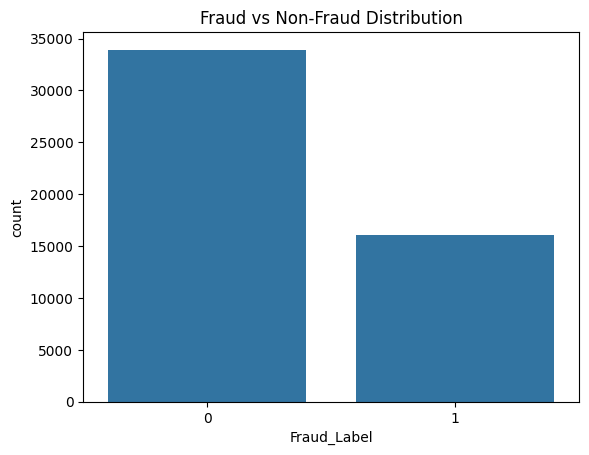

Fraud_Label
0    33933
1    16067
Name: count, dtype: int64

In [8]:
# 9. Visualize class distribution
sns.countplot(x='Fraud_Label', data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()
df['Fraud_Label'].value_counts()

1.5 Checking for Missing Values

In [9]:
print(df.isnull().sum())

Transaction_ID                  0
User_ID                         0
Transaction_Amount              0
Transaction_Type                0
Timestamp                       0
Account_Balance                 0
Device_Type                     0
Location                        0
Merchant_Category               0
IP_Address_Flag                 0
Previous_Fraudulent_Activity    0
Daily_Transaction_Count         0
Avg_Transaction_Amount_7d       0
Failed_Transaction_Count_7d     0
Card_Type                       0
Card_Age                        0
Transaction_Distance            0
Authentication_Method           0
Risk_Score                      0
Is_Weekend                      0
Fraud_Label                     0
Hour                            0
Month                           0
Year                            0
dtype: int64


1.6 Outlier and Distribution Analysis

Boxplots are used to visualize the distribution of the numeric features. The plot for Transaction_Amount clearly shows a high number of outliers.

**A Note on Outliers in Fraud Detection**: While these extreme values are statistically outliers, they cannot be simply removed. In fraud detection, an unusually large or rare transaction is often a strong signal of fraudulent activity. These extreme values are precisely the cases we need our model to learn from. Our analysis of these outliers confirmed they contained a mix of both fraudulent and non-fraudulent transactions, reinforcing the decision to keep them in the dataset.

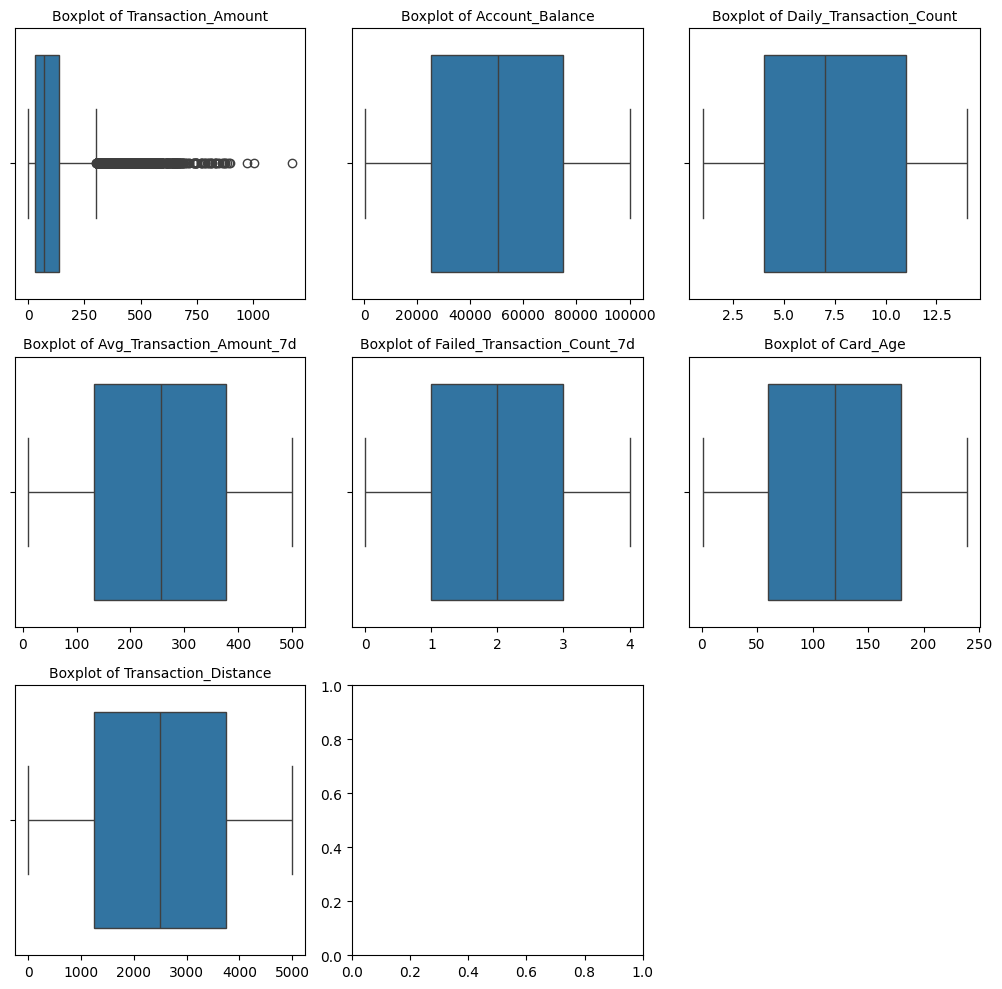

In [10]:
# Boxplots for numeric variables
numeric_cols = df[numeric_features]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:8]):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}', fontsize=10)
    axes[i].set_xlabel('')

for j in range(len(numeric_cols[:8]), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

1.7 Categorical and Boolean Feature Overview

In [11]:
boolean_categorical_features = boolean_features + categorical_features + [target]

# Create an empty dictionary to store feature information
feature_info = {}

# Loop through features and extract information
for feature in boolean_categorical_features:
  feature_info[feature] = {
      'Unique Values': df[feature].unique().tolist(),
      'Most Frequent Value': df[feature].mode()[0],
      'Frequency': df[feature].value_counts().max()
  }

# Create a DataFrame from the dictionary
feature_description_df = pd.DataFrame.from_dict(feature_info, orient='index')

# Display the DataFrame
display(feature_description_df)

,Unique Values,Most Frequent Value,Frequency
IP_Address_Flag,"[0, 1]",0,47490
Is_Weekend,"[0, 1]",0,35018
Previous_Fraudulent_Activity,"[0, 1]",0,45080
Transaction_Type,"[POS, Bank Transfer, Online, ATM Withdrawal]",POS,12549
Device_Type,"[Laptop, Mobile, Tablet]",Tablet,16779
Location,"[Sydney, New York, Mumbai, Tokyo, London]",Tokyo,10208
Merchant_Category,"[Travel, Clothing, Restaurants, Electronics, G...",Clothing,10033
Card_Type,"[Amex, Mastercard, Visa, Discover]",Mastercard,12693
Authentication_Method,"[Biometric, Password, OTP, PIN]",Biometric,12591
Hour,"[19, 4, 15, 0, 23, 20, 1, 3, 22, 17, 7, 8, 9, ...",11,2200


**2.1 Data Preparation for Modeling**

Before building our predictive models, we prepare the data:

1/ **Drop Excluded Features**: Remove identifier columns and Risk_Score.

2/ **Train-Test Split**: Split the data into training (75%) and testing (25%) sets, stratified by the target variable y to maintain class proportions.

3/ **One-Hot Encoding**: Categorical features are converted into a numerical format. We chose one-hot encoding because the features are nominal (not ordinal), and this method prevents distance-based models from misinterpreting them as having an ordered relationship.

4/ **Feature Scaling**: Numerical features are standardized to have a mean of 0 and a standard deviation of 1. This is crucial for models sensitive to feature scales, like SVC and KNN.

In [12]:
df = df.drop(columns=exclude_features)

# Split the data
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Create and fit the encoder on training data only
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoder.fit(X_train[categorical_features])

# Transform both training and test data
X_train_encoded = one_hot_encoder.transform(X_train[categorical_features])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_features])

# Get new column names
new_column_names = one_hot_encoder.get_feature_names_out(categorical_features)

# Create DataFrames with the encoded features
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=new_column_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=new_column_names, index=X_test.index)

# Concatenate with the non-categorical features
X_train_final = pd.concat([X_train.drop(columns=categorical_features), X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test.drop(columns=categorical_features), X_test_encoded_df], axis=1)

# Scale numerical features
scaler = StandardScaler()
X_train_final[numeric_features] = scaler.fit_transform(X_train_final[numeric_features])
X_test_final[numeric_features] = scaler.transform(X_test_final[numeric_features])

2.2 Model 1: Decision Tree Classifier & Handling Imbalance

The Decision Tree is our baseline model to evaluate strategies for handling the imbalanced dataset.

**Key Consideration**: In fraud detection, correctly identifying fraudulent transactions (high recall for class 1) is often more critical than overall accuracy, as missing a fraudulent case can be very costly.


We test three approaches:


1. No Resampling: The model trained on the original data achieves a recall of 0.68 for fraud.
2. SMOTE (Oversampling): This slightly lowers precision but maintains a recall of 0.68.
3. NearMiss (Undersampling): This significantly improves fraud recall to 0.76 but at a great cost to precision (0.50) and overall performance.

**Decision**: Although resampling did not provide a clear "winner" in improving overall F1-scores, the analysis showed the importance of balancing precision and recall. For the subsequent models in this notebook, we will proceed with the **original imbalanced dataset**. This avoids introducing synthetic data (from SMOTE) or losing potentially valuable majority-class information (from NearMiss), providing a more direct comparison of the algorithms' inherent abilities to handle this data.

In [13]:
print('Decision Tree Classifier')
m1 = DecisionTreeClassifier(random_state=42)
m1.fit(X_train_final, y_train)
print(classification_report(y_test, m1.predict(X_test_final)))

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_final, y_train)
m1.fit(X_train_resampled, y_train_resampled)
print('Decision Tree Classifier with SMOTE')
print(classification_report(y_test, m1.predict(X_test_final)))

nr = NearMiss()
X_train_nr_resampled, y_train_nr_resampled = nr.fit_resample(X_train_final, y_train)
m1.fit(X_train_nr_resampled, y_train_nr_resampled)
print('Decision Tree Classifier with NearMiss')
print(classification_report(y_test, m1.predict(X_test_final)))

Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      8483
           1       0.66      0.68      0.67      4017

    accuracy                           0.78     12500
   macro avg       0.75      0.76      0.75     12500
weighted avg       0.79      0.78      0.78     12500

Decision Tree Classifier with SMOTE
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      8483
           1       0.65      0.68      0.66      4017

    accuracy                           0.78     12500
   macro avg       0.75      0.75      0.75     12500
weighted avg       0.78      0.78      0.78     12500

Decision Tree Classifier with NearMiss
              precision    recall  f1-score   support

           0       0.85      0.64      0.73      8483
           1       0.50      0.76      0.60      4017

    accuracy                           0.68     12500
   macro avg       0.67     

Decision Tree Feature Importance

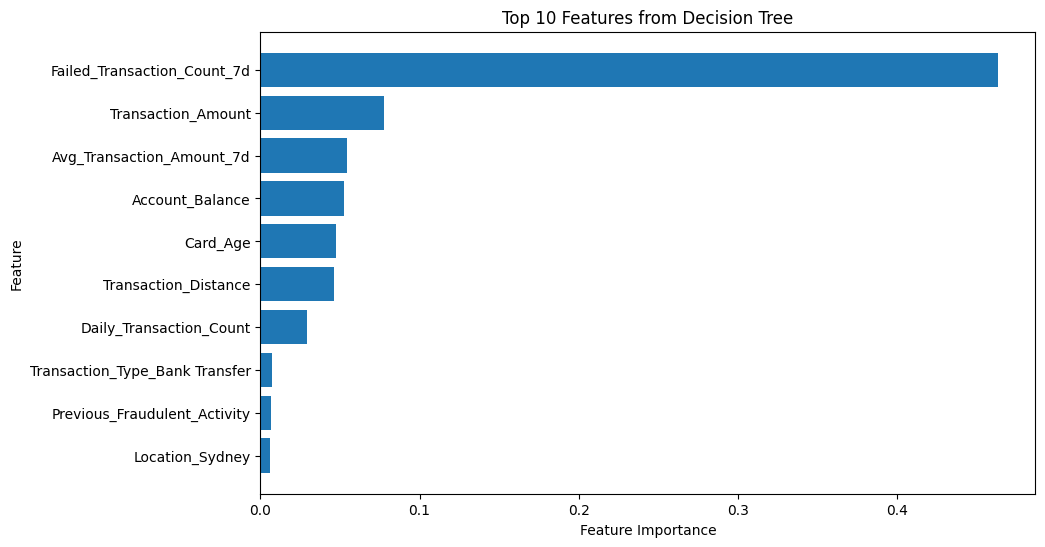

,Feature,Importance
6,Failed_Transaction_Count_7d,0.463738
0,Transaction_Amount,0.077612
5,Avg_Transaction_Amount_7d,0.054260
1,Account_Balance,0.052543
7,Card_Age,0.047591
8,Transaction_Distance,0.046154
4,Daily_Transaction_Count,0.029512
11,Transaction_Type_Bank Transfer,0.007027
3,Previous_Fraudulent_Activity,0.006624
20,Location_Sydney,0.006195


In [14]:
importances = m1.feature_importances_
feature_names = X_train_final.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:top_n], feature_importance_df['Importance'][:top_n])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features from Decision Tree")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()
feature_importance_df.head(10)

2.3 Model 2: Random Forest Classifier

In [15]:
# Original model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train_final, y_train)
print('\n[Original] Random Forest Classifier')
print(classification_report(y_test, rf_model.predict(X_test_final)))

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Fit and predict
grid_search.fit(X_train_final, y_train)
best_rf_model = grid_search.best_estimator_

print('\n[Tuned] Random Forest Classifier (Best Params):')
print(grid_search.best_params_)
print(classification_report(y_test, best_rf_model.predict(X_test_final)))


[Original] Random Forest Classifier
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500

Fitting 3 folds for each of 12 candidates, totalling 36 fits

[Tuned] Random Forest Classifier (Best Params):
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500



**mena**

In [16]:
# --- Nouvelle approche : Random Forest Calibré avec Sous-échantillonnage (Ratio 0.7) ---

from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
import numpy as np
import pandas as pd

# 1. Sous-échantillonnage avec un ratio de 70%
# On utilise les données déjà prétraitées : X_train_final
rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_final, y_train)

print("--- Distribution des classes après sous-échantillonnage (Ratio 0.7) ---")
print(pd.Series(y_train_rus).value_counts())

# 2. Créer et entraîner le modèle Random Forest calibré
# Le modèle de base
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Le wrapper de calibration
rf_calibrated = CalibratedClassifierCV(rf_base, method='sigmoid', cv=3, n_jobs=-1)

# Entraînement sur les données sous-échantillonnées
rf_calibrated.fit(X_train_rus, y_train_rus)

# 3. Prédiction des probabilités sur l'ensemble de test
# On utilise les données de test prétraitées : X_test_final
y_proba = rf_calibrated.predict_proba(X_test_final)[:, 1]

# 4. Trouver le seuil optimal basé sur le F1-score
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
# Calculer F1 pour chaque seuil, en évitant la division par zéro
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)

# Ignorer le dernier score car il correspond à un seuil non défini
optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]
print(f"\nSeuil optimal trouvé : {optimal_threshold:.4f}")

# 5. Évaluation avec les deux seuils

# Évaluation avec le seuil par défaut (0.5)
y_pred_default = (y_proba >= 0.5).astype(int)
print("\n--- Performance avec Seuil par Défaut (0.5) ---")
print(classification_report(y_test, y_pred_default))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_default))
    
# Évaluation avec le seuil optimal
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
print(f"\n--- Performance avec Seuil Optimal ({optimal_threshold:.4f}) ---")
print(classification_report(y_test, y_pred_optimal))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_optimal))

--- Distribution des classes après sous-échantillonnage (Ratio 0.7) ---
Fraud_Label
0    17214
1    12050
Name: count, dtype: int64

Seuil optimal trouvé : 0.9639

--- Performance avec Seuil par Défaut (0.5) ---
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500

Matrice de confusion :
[[8482    1]
 [1539 2478]]

--- Performance avec Seuil Optimal (0.9639) ---
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500

Matrice de confusion :
[[8483    0]

--- Analyse pour un Seuil Optimisé (Précision >= 0.8) ---
Nouveau seuil optimal trouvé : 0.2978
À ce seuil, Précision = 0.80, Rappel = 0.65

--- Performance avec le nouveau seuil optimal (0.2978) ---
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      8483
           1       0.80      0.65      0.72      4017

    accuracy                           0.84     12500
   macro avg       0.82      0.79      0.80     12500
weighted avg       0.83      0.84      0.83     12500

Matrice de confusion :
[[7832  651]
 [1411 2606]]


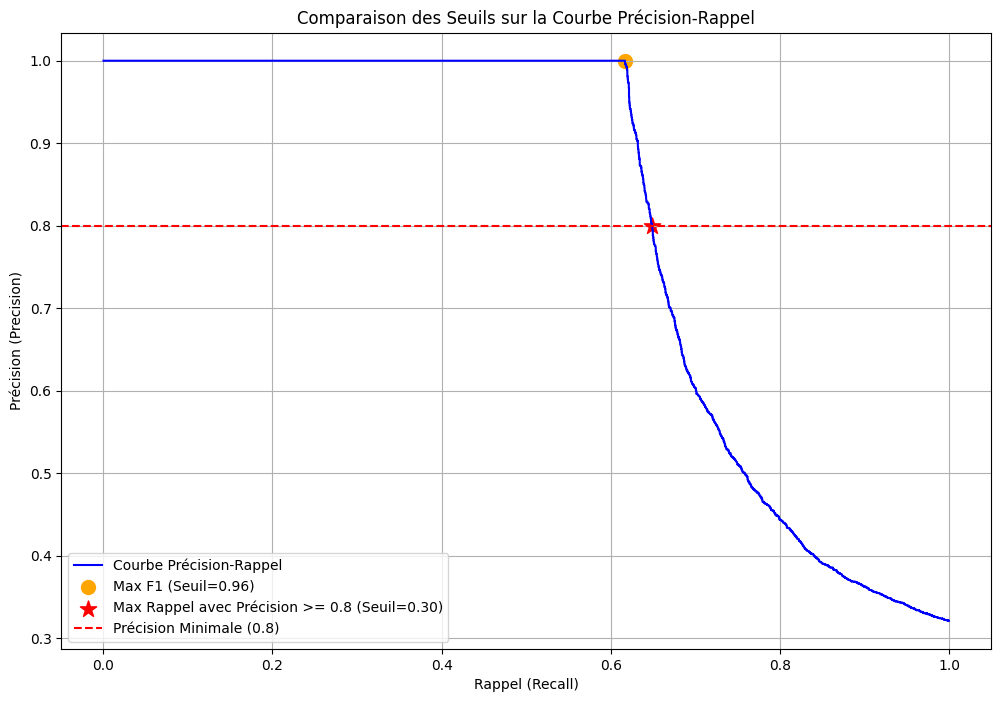

In [17]:
# --- Recherche d'un Seuil Optimisé pour un Rappel Élevé ---

# On suppose que les variables `y_proba`, `y_test`, `precision`, `recall`, 
# et `thresholds` sont déjà calculées dans la cellule précédente.

# 1. Définir la contrainte de précision minimale
# Vous pouvez ajuster cette valeur. Par exemple, 0.85 signifie qu'on accepte
# que 15% des alertes soient des faux positifs au maximum.
MIN_PRECISION = 0.80

# 2. Trouver le meilleur seuil sous cette contrainte
# On ignore le dernier élément de `precision` et `recall` car `thresholds` a une taille n-1
valid_indices = np.where(precision[:-1] >= MIN_PRECISION)[0]

# Parmi ces indices valides, trouver celui qui maximise le rappel
best_idx_for_recall = valid_indices[np.argmax(recall[valid_indices])]

# Obtenir le seuil et les performances correspondantes
new_optimal_threshold = thresholds[best_idx_for_recall]
recall_at_threshold = recall[best_idx_for_recall]
precision_at_threshold = precision[best_idx_for_recall]

print(f"--- Analyse pour un Seuil Optimisé (Précision >= {MIN_PRECISION}) ---")
print(f"Nouveau seuil optimal trouvé : {new_optimal_threshold:.4f}")
print(f"À ce seuil, Précision = {precision_at_threshold:.2f}, Rappel = {recall_at_threshold:.2f}")

    # 3. Appliquer le nouveau seuil pour obtenir les prédictions
y_pred_new_optimal = (y_proba >= new_optimal_threshold).astype(int)

# 4. Afficher le rapport de classification et la matrice de confusion
print(f"\n--- Performance avec le nouveau seuil optimal ({new_optimal_threshold:.4f}) ---")
print(classification_report(y_test, y_pred_new_optimal))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_new_optimal))

# 5. Visualisation pour comparer les points de fonctionnement

# Ancien seuil optimal (basé sur F1-score)
f1_optimal_idx = np.argmax(f1_scores[:-1])
f1_optimal_threshold = thresholds[f1_optimal_idx]
f1_recall = recall[f1_optimal_idx]
f1_precision = precision[f1_optimal_idx]

plt.figure(figsize=(12, 8))
plt.plot(recall[:-1], precision[:-1], 'b-', label='Courbe Précision-Rappel')
plt.xlabel('Rappel (Recall)')
plt.ylabel('Précision (Precision)')
plt.title('Comparaison des Seuils sur la Courbe Précision-Rappel')

# Marquer le point optimisé pour F1
plt.scatter(f1_recall, f1_precision, marker='o', color='orange', s=100, label=f'Max F1 (Seuil={f1_optimal_threshold:.2f})')
# Marquer le nouveau point optimisé pour le rappel
plt.scatter(recall_at_threshold, precision_at_threshold, marker='*', color='red', s=150, label=f'Max Rappel avec Précision >= {MIN_PRECISION} (Seuil={new_optimal_threshold:.2f})')

plt.axhline(y=MIN_PRECISION, color='r', linestyle='--', label=f'Précision Minimale ({MIN_PRECISION})')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [18]:
import pandas as pd

# Fraud transaction example

# new_transaction_data = {
#     'Transaction_Amount': 5000.00,                  # Unusually high for the account
#     'Transaction_Type': 'Debit',                    # Money going out
#     'Account_Balance': 5200.00,                      # Nearly full balance being drained
#     'Device_Type': 'Web',                            # Not the usual device
#     'Location': 'Nigeria',                           # Different country than normal
#     'Merchant_Category': 'Electronics',              # High resale value items
#     'IP_Address_Flag': 1,                            # IP flagged as suspicious
#     'Previous_Fraudulent_Activity': 1,               # Has previous fraud history
#     'Daily_Transaction_Count': 7,                    # Many transactions in one day
#     'Avg_Transaction_Amount_7d': 150.00,              # Normally small transactions
#     'Failed_Transaction_Count_7d': 4,                # Multiple recent failed attempts
#     'Card_Type': 'Visa',                              # Commonly targeted
#     'Card_Age': 0.5,                                  # New card (half a month)
#     'Transaction_Distance': 5000,                     # Very far from normal location
#     'Authentication_Method': 'None',                  # No 2FA or PIN used
#     'Is_Weekend': 1,                                  # Weekend transaction
#     'Hour': 3,                                        # Middle of the night
#     'Month': 8,
#     'Year': 2025
# }


# Legit transaction example

# new_transaction = pd.DataFrame{
#     'Transaction_Amount': 45.00,                     # Small, normal purchase
#     'Transaction_Type': 'Credit',                    # Money coming into the account
#     'Account_Balance': 1200.00,                       # Normal balance
#     'Device_Type': 'Mobile',                          # Usual device for the user
#     'Location': 'Paris',                              # Usual location
#     'Merchant_Category': 'Groceries',                 # Common spending category
#     'IP_Address_Flag': 0,                             # Clean IP
#     'Previous_Fraudulent_Activity': 0,                # No history of fraud
#     'Daily_Transaction_Count': 2,                     # Normal daily activity
#     'Avg_Transaction_Amount_7d': 40.00,               # Similar to usual amounts
#     'Failed_Transaction_Count_7d': 0,                 # No failed transactions
#     'Card_Type': 'MasterCard',                        # Usual card
#     'Card_Age': 24,                                   # Card held for 2 years
#     'Transaction_Distance': 2,                        # Local transaction
#     'Authentication_Method': 'PIN',                   # Secure authentication
#     'Is_Weekend': 0,                                  # Weekday
#     'Hour': 17,                                       # Afternoon shopping
#     'Month': 8,
#     'Year': 2025
# }

In [19]:
# --- Test en Conditions Réelles : Évaluation d'une Nouvelle Transaction (Corrigé) ---

import joblib
import pandas as pd
import numpy as np

# 1. Exporter les objets nécessaires
# Le modèle est `rf_calibrated`
# Les `scaler` et `one_hot_encoder` ont été créés dans les premières cellules
# `X_train_final.columns` nous donne l'ordre final des caractéristiques

print("Exportation des fichiers nécessaires...")
joblib.dump(rf_calibrated, 'fraud_model_calibrated.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(one_hot_encoder, 'encoder.pkl')
joblib.dump(X_train_final.columns.tolist(), 'feature_order.pkl')
print("Modèle et transformateurs exportés.")

# 2. Charger les objets pour le test
loaded_model = joblib.load('fraud_model_calibrated.pkl')
loaded_scaler = joblib.load('scaler.pkl')
loaded_encoder = joblib.load('encoder.pkl')
loaded_feature_order = joblib.load('feature_order.pkl')
print("Modèle et transformateurs chargés.")

# 3. Simuler une nouvelle transaction
# Legit transaction example
# new_transaction_data = {
#     'Transaction_Amount': 45.00,                     # Small, normal purchase
#     'Transaction_Type': 'Credit',                    # Money coming into the account
#     'Account_Balance': 1200.00,                       # Normal balance
#     'Device_Type': 'Mobile',                          # Usual device for the user
#     'Location': 'Paris',                              # Usual location
#     'Merchant_Category': 'Groceries',                 # Common spending category
#     'IP_Address_Flag': 0,                             # Clean IP
#     'Previous_Fraudulent_Activity': 0,                # No history of fraud
#     'Daily_Transaction_Count': 2,                     # Normal daily activity
#     'Avg_Transaction_Amount_7d': 40.00,               # Similar to usual amounts
#     'Failed_Transaction_Count_7d': 0,                 # No failed transactions
#     'Card_Type': 'MasterCard',                        # Usual card
#     'Card_Age': 24,                                   # Card held for 2 years
#     'Transaction_Distance': 2,                        # Local transaction
#     'Authentication_Method': 'PIN',                   # Secure authentication
#     'Is_Weekend': 0,                                  # Weekday
#     'Hour': 17,                                       # Afternoon shopping
#     'Month': 8,
#     'Year': 2025
# }
# Fraud transaction example

# new_transaction_data = {
#     'Transaction_Amount': 5000.00,                  # Unusually high for the account
#     'Transaction_Type': 'Debit',                    # Money going out
#     'Account_Balance': 5200.00,                      # Nearly full balance being drained
#     'Device_Type': 'Web',                            # Not the usual device
#     'Location': 'Nigeria',                           # Different country than normal
#     'Merchant_Category': 'Electronics',              # High resale value items
#     'IP_Address_Flag': 1,                            # IP flagged as suspicious
#     'Previous_Fraudulent_Activity': 1,               # Has previous fraud history
#     'Daily_Transaction_Count': 7,                    # Many transactions in one day
#     'Avg_Transaction_Amount_7d': 150.00,              # Normally small transactions
#     'Failed_Transaction_Count_7d': 4,                # Multiple recent failed attempts
#     'Card_Type': 'Visa',                              # Commonly targeted
#     'Card_Age': 0.5,                                  # New card (half a month)
#     'Transaction_Distance': 5000,                     # Very far from normal location
#     'Authentication_Method': 'None',                  # No 2FA or PIN used
#     'Is_Weekend': 1,                                  # Weekend transaction
#     'Hour': 3,                                        # Middle of the night
#     'Month': 8,
#     'Year': 2025
# }
new_transaction_data ={
  "Transaction_Amount": 2100.0,
  "Transaction_Type": "Debit",
  "Account_Balance": 9000.0,
  "Device_Type": "Web",
  "Location": "Tokyo",
  "Merchant_Category": "Electronics",
  "IP_Address_Flag": 0,
  "Previous_Fraudulent_Activity": 0,
  "Daily_Transaction_Count": 1,
  "Avg_Transaction_Amount_7d": 1800.0,
  "Failed_Transaction_Count_7d": 0,
  "Card_Type": "MasterCard",
  "Card_Age": 60,
  "Transaction_Distance": 9800,
  "Authentication_Method": "OTP",
  "Is_Weekend": 1,
  "Hour": 11,
  "Month": 8,
  "Year": 2025
}

new_transaction = pd.DataFrame([new_transaction_data])

# 4. Prétraiter la nouvelle transaction en utilisant les objets chargés
# Définir les listes de caractéristiques
categorical_features = ['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category',
                        'Card_Type', 'Authentication_Method', 'Hour', 'Month', 'Year']
numeric_features = ['Transaction_Amount', 'Account_Balance', 'Daily_Transaction_Count',
                    'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age',
                    'Transaction_Distance']
boolean_features = ['IP_Address_Flag', 'Is_Weekend', 'Previous_Fraudulent_Activity']

# Appliquer l'encodage et la mise à l'échelle
encoded_cats = loaded_encoder.transform(new_transaction[categorical_features])
scaled_nums = loaded_scaler.transform(new_transaction[numeric_features])

# Reconstruire le DataFrame
encoded_df = pd.DataFrame(encoded_cats, columns=loaded_encoder.get_feature_names_out(categorical_features))
scaled_df = pd.DataFrame(scaled_nums, columns=numeric_features)
booleans_df = new_transaction[boolean_features].reset_index(drop=True)

# Concaténer et réorganiser les colonnes pour correspondre à l'entraînement
processed_transaction = pd.concat([scaled_df, booleans_df, encoded_df], axis=1)
processed_transaction = processed_transaction.reindex(columns=loaded_feature_order, fill_value=0)

# 5. Faire la prédiction
prediction_proba = loaded_model.predict_proba(processed_transaction)[0]
fraud_probability = prediction_proba[1]

# Utiliser le seuil optimal trouvé précédemment
final_prediction = 1 if fraud_probability >= new_optimal_threshold else 0

# 6. Afficher le rapport
print("\n--- Analyse de la Nouvelle Transaction ---")
print(f"Probabilité de fraude : {fraud_probability:.2%}")
print(f"Seuil de décision : {new_optimal_threshold:.2%}")
print("\n>> Résultat : Transaction signalée comme FRAUDULEUSE <<") if final_prediction == 1 else print("\n>> Résultat : Transaction considérée comme LÉGITIME <<")

Exportation des fichiers nécessaires...
Modèle et transformateurs exportés.
Modèle et transformateurs chargés.

--- Analyse de la Nouvelle Transaction ---
Probabilité de fraude : 48.32%
Seuil de décision : 29.78%

>> Résultat : Transaction signalée comme FRAUDULEUSE <<


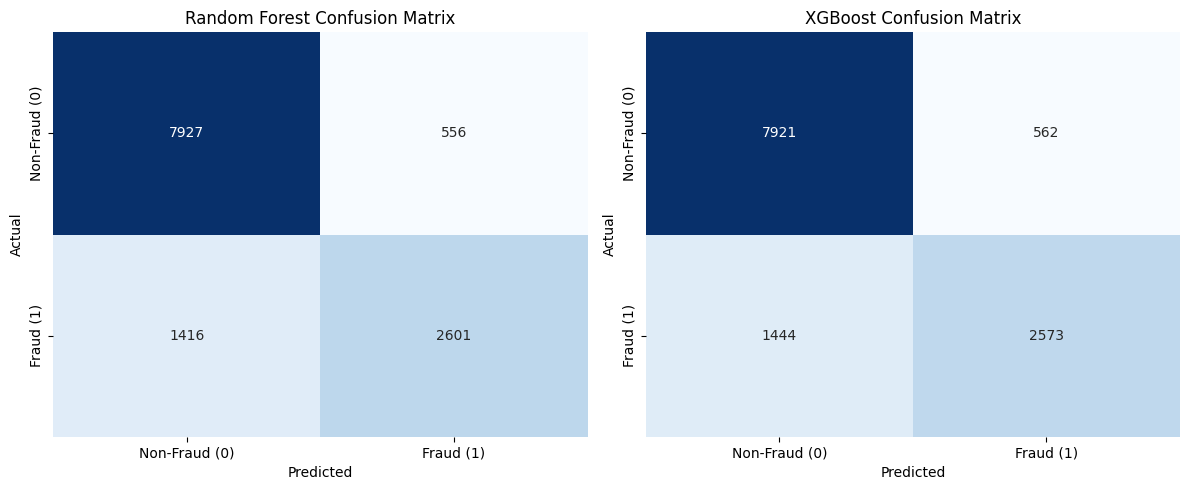

[[[7927, 556], [1416, 2601]], [[7921, 562], [1444, 2573]]]


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrices
cm_rf = [[7927, 556],   # Random Forest
         [1416, 2601]]

cm_xgb = [[7921, 562],  # XGBoost (approx based on recall 0.64)
          [1444, 2573]]

models = ['Random Forest', 'XGBoost']
cms = [cm_rf, cm_xgb]

plt.figure(figsize=(12, 5))

for i, cm in enumerate(cms):
    plt.subplot(1, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{models[i]} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
    plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])

plt.tight_layout()
plt.show()


print(cms)

In [21]:
# --- 6. Exporter le Modèle Final et les Transformateurs ---
import joblib

# Le modèle est `rf_calibrated` de la cellule précédente
# Les `scaler` et `one_hot_encoder` ont été créés dans les premières étapes de prétraitement
# `X_train_final` contient les données avec le bon ordre de colonnes

print("Exportation des fichiers nécessaires...")

# 1. Sauvegarder le modèle calibré
joblib.dump(rf_calibrated, 'fraud_model_calibrated.pkl')

# 2. Sauvegarder le scaler pour les données numériques
joblib.dump(scaler, 'scaler.pkl')

# 3. Sauvegarder l'encodeur pour les données catégorielles
joblib.dump(one_hot_encoder, 'encoder.pkl')

# 4. Sauvegarder l'ordre des colonnes (TRÈS IMPORTANT)
joblib.dump(X_train_final.columns.tolist(), 'feature_order.pkl')

print("Modèle et transformateurs exportés avec succès !")
print("Fichiers créés : fraud_model_calibrated.pkl, scaler.pkl, encoder.pkl, feature_order.pkl")

Exportation des fichiers nécessaires...
Modèle et transformateurs exportés avec succès !
Fichiers créés : fraud_model_calibrated.pkl, scaler.pkl, encoder.pkl, feature_order.pkl


Distribution des classes après sous-échantillonnage:
Fraud_Label
0    12050
1    12050
Name: count, dtype: int64

--- Performance avec seuil par défaut (0.5) ---
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500


--- Performance avec seuil optimal (0.870) ---
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500



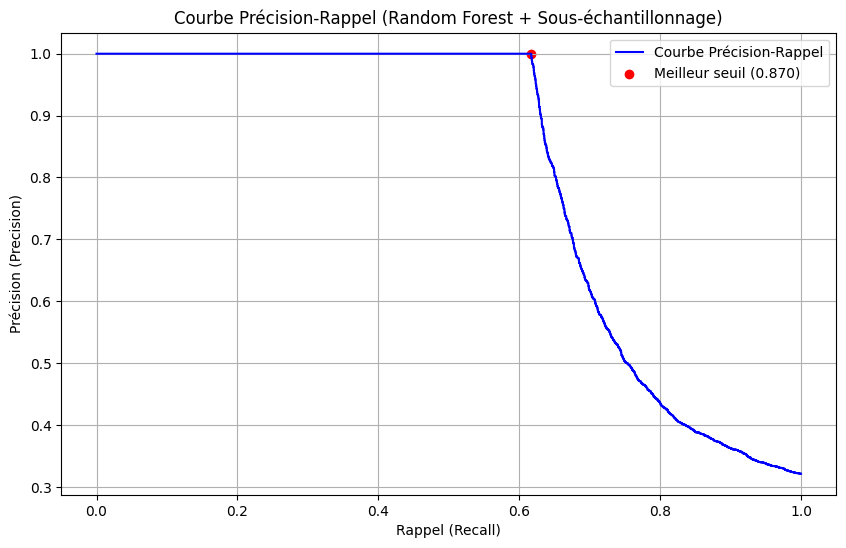

In [22]:
# 1. Appliquer RandomUnderSampler sur les données déjà prétraitées
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Création du sous-échantillonneur
rus = RandomUnderSampler(random_state=42)

# Application du sous-échantillonnage sur les données d'entraînement déjà encodées et mises à l'échelle
X_train_rus, y_train_rus = rus.fit_resample(X_train_final, y_train)

# Afficher la distribution des classes pour vérifier
print("Distribution des classes après sous-échantillonnage:")
print(pd.Series(y_train_rus).value_counts())

# 2. Créer et entraîner le modèle Random Forest
rf_model_rus = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Entraînement du modèle sur les données équilibrées
rf_model_rus.fit(X_train_rus, y_train_rus)

# 3. Évaluation avec le seuil par défaut (0.5)
y_pred_default = rf_model_rus.predict(X_test_final)
print("\n--- Performance avec seuil par défaut (0.5) ---")
print(classification_report(y_test, y_pred_default))

# 4. Optimisation du seuil pour un meilleur équilibre précision/rappel
probas = rf_model_rus.predict_proba(X_test_final)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probas)

# Calcul du F1 score pour chaque seuil pour trouver le meilleur
# Ajout d'un epsilon pour éviter la division par zéro
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

# Trouver le seuil qui maximise le F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Appliquer le seuil optimal
y_pred_optimized = (probas >= optimal_threshold).astype(int)

print(f"\n--- Performance avec seuil optimal ({optimal_threshold:.3f}) ---")
print(classification_report(y_test, y_pred_optimized))

# 5. Visualisation de la courbe precision-recall
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', label='Courbe Précision-Rappel')
plt.xlabel('Rappel (Recall)')
plt.ylabel('Précision (Precision)')
plt.title('Courbe Précision-Rappel (Random Forest + Sous-échantillonnage)')
plt.scatter(recalls[optimal_idx], precisions[optimal_idx], marker='o', color='red', label=f'Meilleur seuil ({optimal_threshold:.3f})')
plt.legend()
plt.grid(True)
plt.show()

Distribution des classes avant sous-échantillonnage:
Non-fraude: 25450
Fraude: 12050

Distribution des classes après sous-échantillonnage:
Non-fraude: 12050
Fraude: 12050

Performance avec seuil par défaut (0.5):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500


Performance avec seuil optimal:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500

Seuil optimal: 0.878


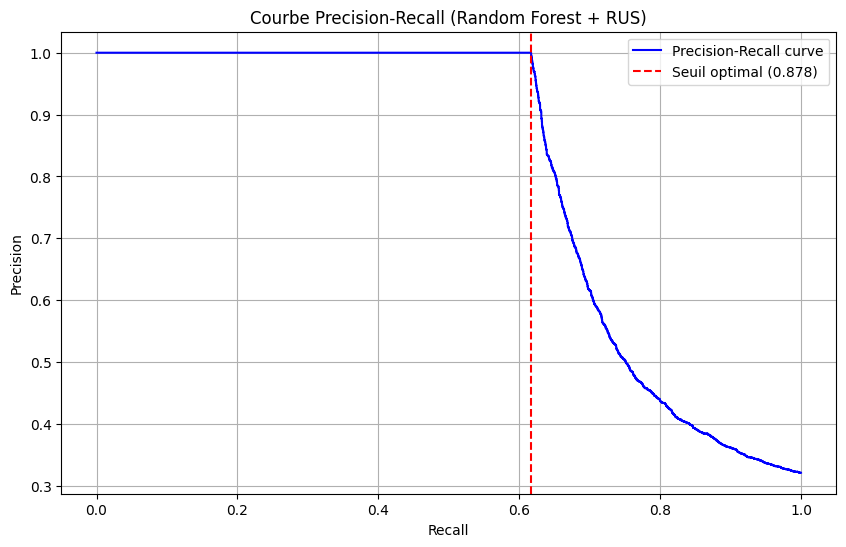

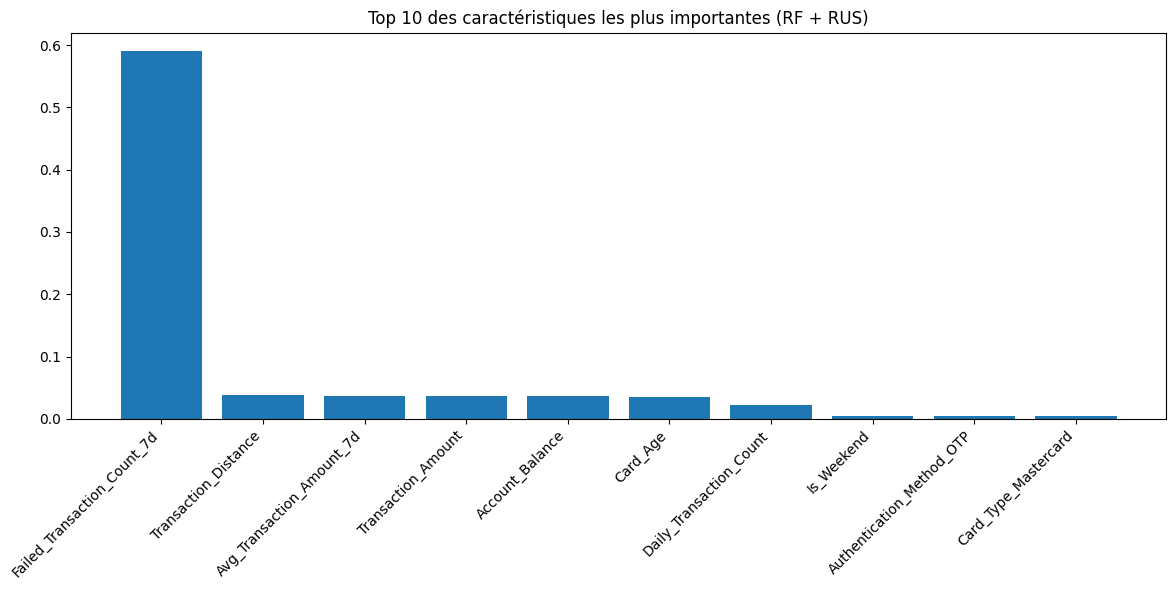


Top 10 des caractéristiques les plus importantes:
                        feature  importance
6   Failed_Transaction_Count_7d    0.590095
8          Transaction_Distance    0.038298
5     Avg_Transaction_Amount_7d    0.037340
0            Transaction_Amount    0.037269
1               Account_Balance    0.037066
7                      Card_Age    0.034612
4       Daily_Transaction_Count    0.021901
9                    Is_Weekend    0.005150
32    Authentication_Method_OTP    0.004250
29         Card_Type_Mastercard    0.004245


In [23]:
# 1. Appliquer RandomUnderSampler sur les données prétraitées
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve

# Création du sous-échantillonneur
rus = RandomUnderSampler(random_state=42)

# Application du sous-échantillonnage sur les données d'entraînement
X_train_rus, y_train_rus = rus.fit_resample(X_train_final, y_train)

# Afficher la distribution des classes
print("Distribution des classes avant sous-échantillonnage:")
print("Non-fraude:", sum(y_train == 0))
print("Fraude:", sum(y_train == 1))

print("\nDistribution des classes après sous-échantillonnage:")
print("Non-fraude:", sum(y_train_rus == 0))
print("Fraude:", sum(y_train_rus == 1))

# 2. Créer et entraîner le Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Entraînement du modèle
rf_model.fit(X_train_rus, y_train_rus)

# 3. Évaluation avec seuil par défaut
y_pred = rf_model.predict(X_test_final)
print("\nPerformance avec seuil par défaut (0.5):")
print(classification_report(y_test, y_pred))

# 4. Optimisation du seuil
probas = rf_model.predict_proba(X_test_final)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probas)

# Calcul du F1 score pour chaque seuil
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Application du seuil optimal
y_pred_optimized = (probas >= optimal_threshold).astype(int)

print("\nPerformance avec seuil optimal:")
print(classification_report(y_test, y_pred_optimized))
print(f"Seuil optimal: {optimal_threshold:.3f}")

# 5. Visualisation de la courbe precision-recall
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall (Random Forest + RUS)')
plt.axvline(x=recalls[np.argmax(f1_scores)], color='r', linestyle='--', 
            label=f'Seuil optimal ({optimal_threshold:.3f})')
plt.legend()
plt.grid(True)
plt.show()

# 6. Importance des caractéristiques
feature_importances = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(range(10), feature_importances['importance'][:10])
plt.xticks(range(10), feature_importances['feature'][:10], rotation=45, ha='right')
plt.title('Top 10 des caractéristiques les plus importantes (RF + RUS)')
plt.tight_layout()
plt.show()

print("\nTop 10 des caractéristiques les plus importantes:")
print(feature_importances.head(10))

Distribution des classes avant sous-échantillonnage:
Non-fraude: 25450
Fraude: 12050

Distribution des classes après sous-échantillonnage:
Non-fraude: 12050
Fraude: 12050



Performance avec seuil par défaut (0.5):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.89      0.88      0.87     12500


Performance avec seuil optimal:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500

Seuil optimal: 0.982


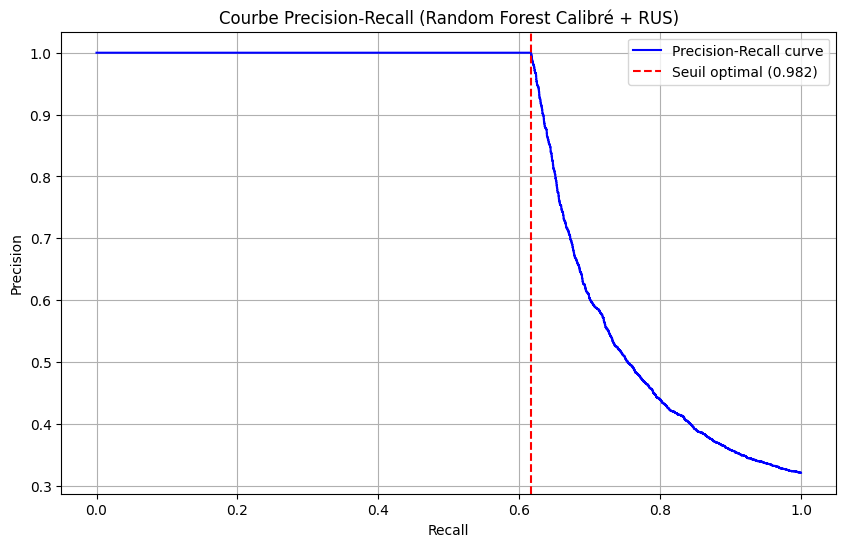

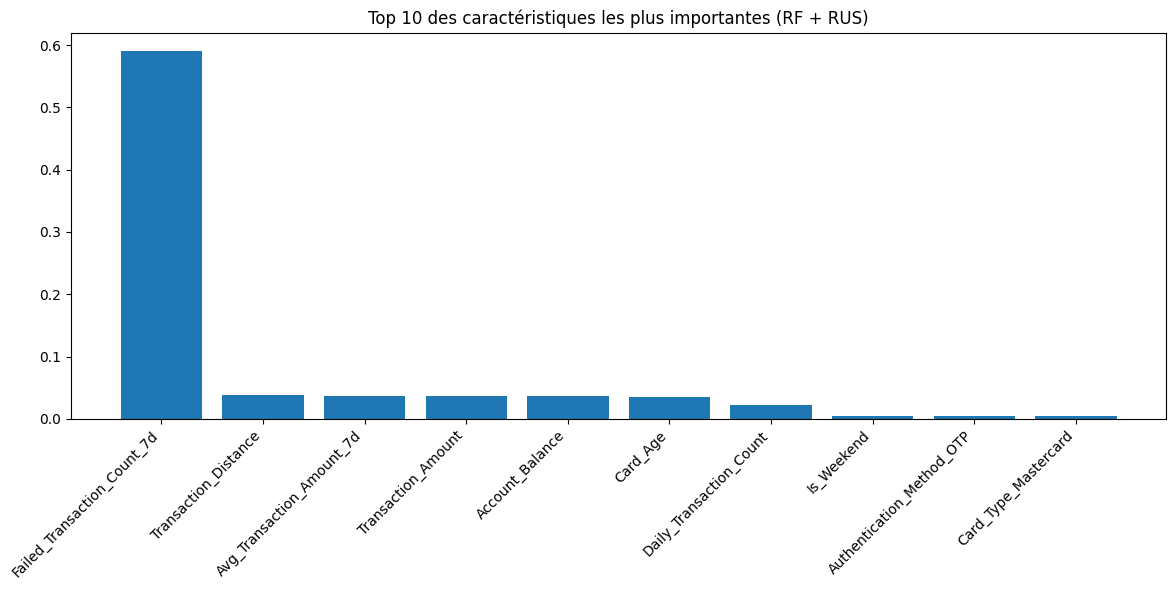


Top 10 des caractéristiques les plus importantes:
                        feature  importance
6   Failed_Transaction_Count_7d    0.590095
8          Transaction_Distance    0.038298
5     Avg_Transaction_Amount_7d    0.037340
0            Transaction_Amount    0.037269
1               Account_Balance    0.037066
7                      Card_Age    0.034612
4       Daily_Transaction_Count    0.021901
9                    Is_Weekend    0.005150
32    Authentication_Method_OTP    0.004250
29         Card_Type_Mastercard    0.004245


In [24]:
# 1. Appliquer RandomUnderSampler sur les données déjà prétraitées
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV

# Sous-échantillonnage des données d'entraînement
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_final, y_train)

print("Distribution des classes avant sous-échantillonnage:")
print("Non-fraude:", sum(y_train == 0))
print("Fraude:", sum(y_train == 1))

print("\nDistribution des classes après sous-échantillonnage:")
print("Non-fraude:", sum(y_train_rus == 0))
print("Fraude:", sum(y_train_rus == 1))

# 2. Créer et entraîner le Random Forest de base
rf_base = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Entraîner d'abord le modèle de base pour obtenir les importances
rf_base.fit(X_train_rus, y_train_rus)

# 3. Créer et entraîner le modèle calibré séparément
rf_calibrated = CalibratedClassifierCV(
    rf_base, 
    method='sigmoid', 
    cv=3,
    n_jobs=-1
)
rf_calibrated.fit(X_train_rus, y_train_rus)

# 4. Évaluer le modèle
# Prédictions avec le seuil par défaut
y_pred_default = rf_calibrated.predict(X_test_final)
print("\nPerformance avec seuil par défaut (0.5):")
print(classification_report(y_test, y_pred_default))

# 5. Optimiser le seuil de décision
probas = rf_calibrated.predict_proba(X_test_final)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probas)

# Calculer le F1 score pour chaque seuil
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Appliquer le seuil optimal
y_pred_optimized = (probas >= optimal_threshold).astype(int)

print("\nPerformance avec seuil optimal:")
print(classification_report(y_test, y_pred_optimized))
print(f"Seuil optimal: {optimal_threshold:.3f}")

# 6. Visualiser la courbe precision-recall
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall (Random Forest Calibré + RUS)')
plt.axvline(x=recalls[np.argmax(f1_scores)], color='r', linestyle='--', 
            label=f'Seuil optimal ({optimal_threshold:.3f})')
plt.legend()
plt.grid(True)
plt.show()

# 7. Visualiser l'importance des caractéristiques (utilisant le modèle de base)
feature_importances = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': rf_base.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(range(10), feature_importances['importance'][:10])
plt.xticks(range(10), feature_importances['feature'][:10], rotation=45, ha='right')
plt.title('Top 10 des caractéristiques les plus importantes (RF + RUS)')
plt.tight_layout()
plt.show()
print("\nTop 10 des caractéristiques les plus importantes:")
print(feature_importances.head(10))

Distribution des classes avant sous-échantillonnage:
Non-fraude: 25450
Fraude: 12050

Distribution des classes après sous-échantillonnage:
Non-fraude: 12050
Fraude: 12050

Performance du modèle Random Forest avec données sous-échantillonnées:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500


Performance avec seuil optimal:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.89      0.88      0.87     12500

Seuil optimal: 0.432


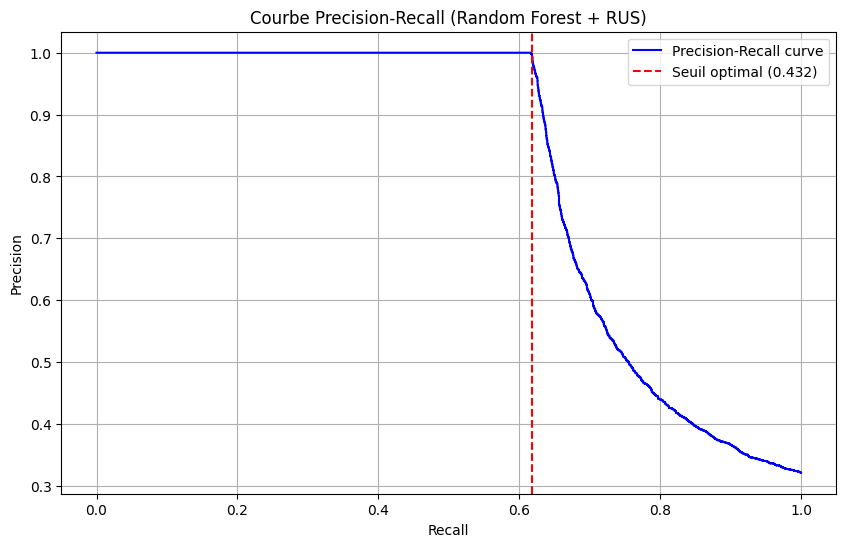

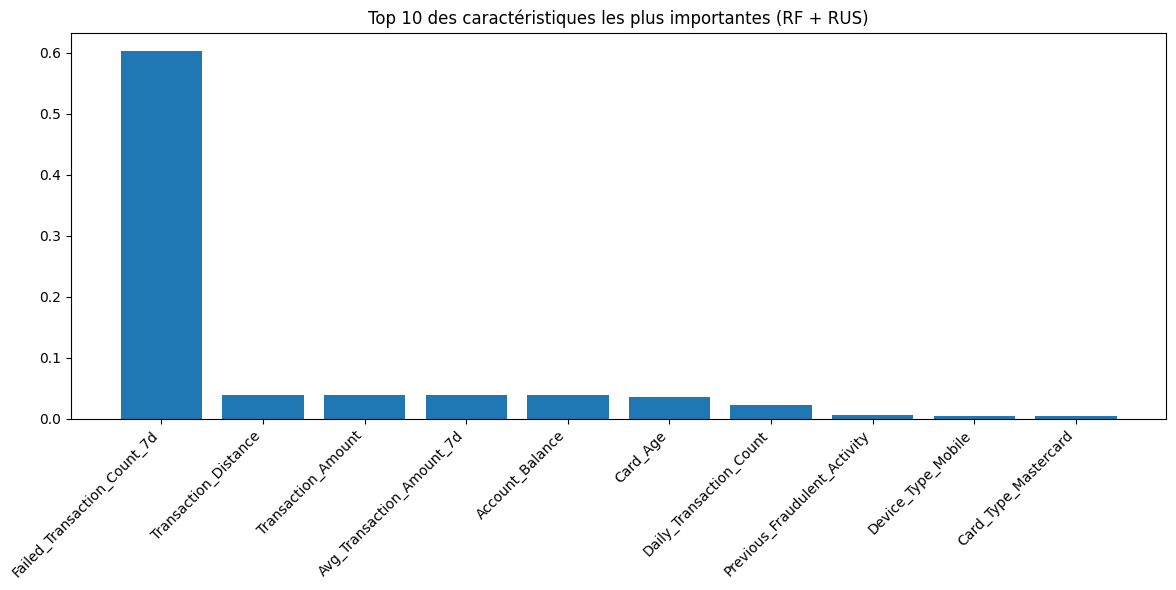


Top 10 des caractéristiques les plus importantes:
                         feature  importance
4    Failed_Transaction_Count_7d    0.602413
6           Transaction_Distance    0.039424
0             Transaction_Amount    0.039206
3      Avg_Transaction_Amount_7d    0.038993
1                Account_Balance    0.038714
5                       Card_Age    0.035845
2        Daily_Transaction_Count    0.022471
62  Previous_Fraudulent_Activity    0.005505
10            Device_Type_Mobile    0.004849
21          Card_Type_Mastercard    0.004762


In [25]:
# 1. Préparation des données
# Définir les colonnes catégorielles et numériques
categorical_features = ['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category',
                       'Card_Type', 'Authentication_Method', 'Hour', 'Month', 'Year']

boolean_features = ['IP_Address_Flag', 'Is_Weekend', 'Previous_Fraudulent_Activity']

numeric_features = ['Transaction_Amount', 'Account_Balance', 'Daily_Transaction_Count',
                   'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age',
                   'Transaction_Distance']

# 2. Encoder les données catégorielles
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Créer le preprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Garde les colonnes booléennes telles quelles
)

# Appliquer le preprocessing
X_processed = preprocessor.fit_transform(X)
feature_names = (numeric_features + 
                [f"{feat}_{val}" for feat, vals in zip(categorical_features, 
                                                      preprocessor.named_transformers_['cat'].categories_) 
                 for val in vals[1:]] +
                boolean_features)

# Convertir en DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# 3. Diviser en train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y, test_size=0.25, random_state=42, stratify=y)

# 4. Appliquer RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print("Distribution des classes avant sous-échantillonnage:")
print("Non-fraude:", sum(y_train == 0))
print("Fraude:", sum(y_train == 1))

print("\nDistribution des classes après sous-échantillonnage:")
print("Non-fraude:", sum(y_train_rus == 0))
print("Fraude:", sum(y_train_rus == 1))

# 5. Entraîner le Random Forest
rf_rus = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Entraîner le modèle
rf_rus.fit(X_train_rus, y_train_rus)

# 6. Évaluer le modèle
y_pred_rus = rf_rus.predict(X_test)
print("\nPerformance du modèle Random Forest avec données sous-échantillonnées:")
print(classification_report(y_test, y_pred_rus))

# 7. Optimiser le seuil
probas_rus = rf_rus.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probas_rus)

# Trouver le meilleur seuil
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Appliquer le seuil optimal
y_pred_rus_optimized = (probas_rus >= optimal_threshold).astype(int)

print("\nPerformance avec seuil optimal:")
print(classification_report(y_test, y_pred_rus_optimized))
print(f"Seuil optimal: {optimal_threshold:.3f}")

# 8. Visualiser la courbe precision-recall
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall (Random Forest + RUS)')
plt.axvline(x=recalls[np.argmax(f1_scores)], color='r', linestyle='--', 
            label=f'Seuil optimal ({optimal_threshold:.3f})')
plt.legend()
plt.grid(True)
plt.show()

# 9. Visualiser l'importance des caractéristiques
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_rus.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(range(10), feature_importances['importance'][:10])
plt.xticks(range(10), feature_importances['feature'][:10], rotation=45, ha='right')
plt.title('Top 10 des caractéristiques les plus importantes (RF + RUS)')
plt.tight_layout()
plt.show()
print("\nTop 10 des caractéristiques les plus importantes:")
print(feature_importances.head(10))

Distribution des classes avant sous-échantillonnage:
Non-fraude: 25450
Fraude: 12050

Distribution des classes après sous-échantillonnage:
Non-fraude: 12050
Fraude: 12050

Performance du modèle Random Forest avec données sous-échantillonnées:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500


Performance avec seuil optimal:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500

Seuil optimal: 0.878


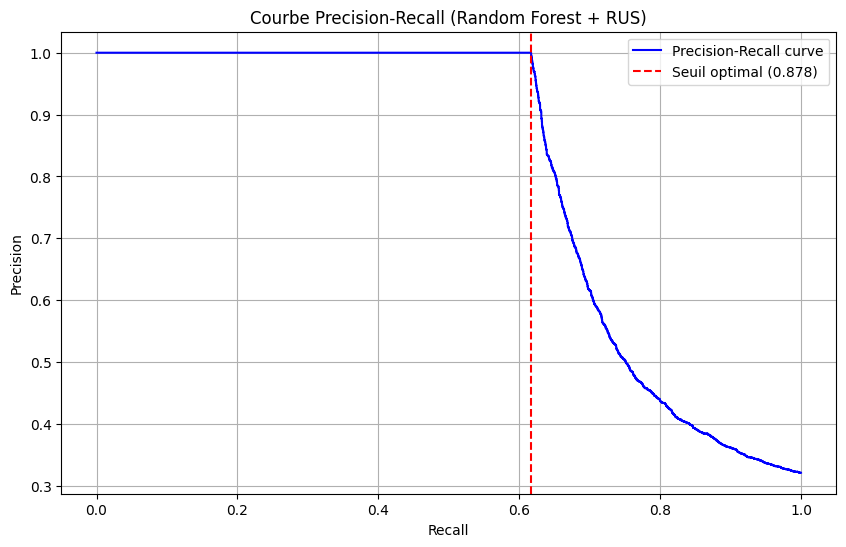

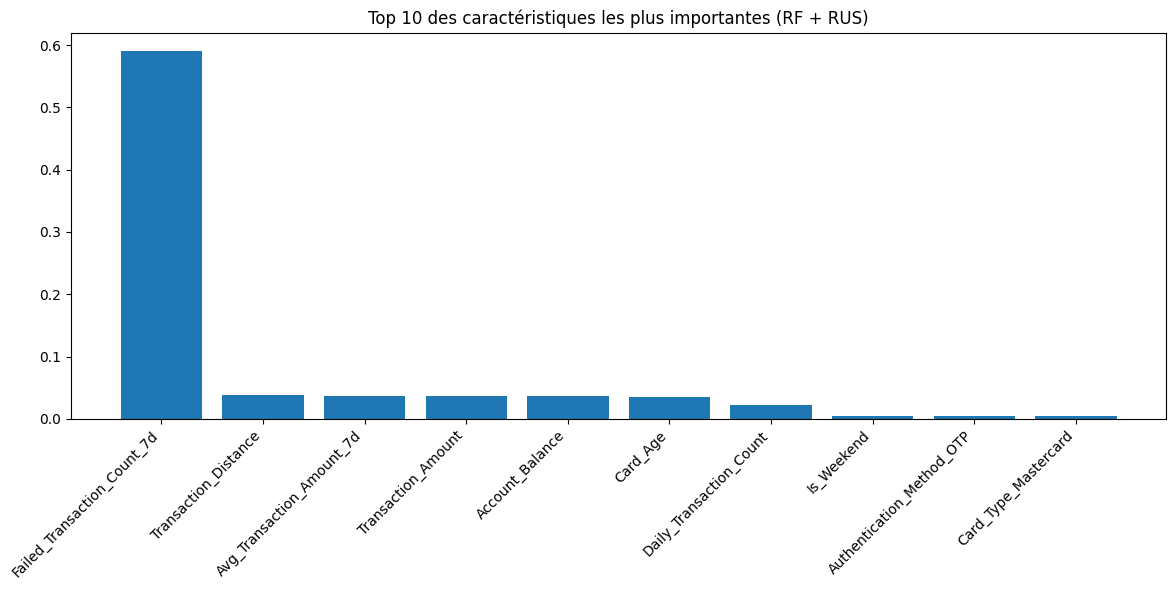


Top 10 des caractéristiques les plus importantes:
                        feature  importance
6   Failed_Transaction_Count_7d    0.590095
8          Transaction_Distance    0.038298
5     Avg_Transaction_Amount_7d    0.037340
0            Transaction_Amount    0.037269
1               Account_Balance    0.037066
7                      Card_Age    0.034612
4       Daily_Transaction_Count    0.021901
9                    Is_Weekend    0.005150
32    Authentication_Method_OTP    0.004250
29         Card_Type_Mastercard    0.004245


In [26]:
# 1. Sous-échantillonnage des données d'entraînement
from imblearn.under_sampling import RandomUnderSampler

# Créer et appliquer le sous-échantillonneur
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_final, y_train)

# Afficher la distribution des classes avant et après
print("Distribution des classes avant sous-échantillonnage:")
print("Non-fraude:", sum(y_train == 0))
print("Fraude:", sum(y_train == 1))

print("\nDistribution des classes après sous-échantillonnage:")
print("Non-fraude:", sum(y_train_rus == 0))
print("Fraude:", sum(y_train_rus == 1))

# 2. Entraîner un Random Forest sur les données équilibrées
rf_rus = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Entraîner le modèle
rf_rus.fit(X_train_rus, y_train_rus)

# 3. Évaluer le modèle
# Prédictions sur l'ensemble de test
y_pred_rus = rf_rus.predict(X_test_final)

# Afficher les métriques de performance
print("\nPerformance du modèle Random Forest avec données sous-échantillonnées:")
print(classification_report(y_test, y_pred_rus))

# 4. Optimiser le seuil de décision
probas_rus = rf_rus.predict_proba(X_test_final)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probas_rus)

# Trouver le meilleur seuil
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Appliquer le seuil optimal
y_pred_rus_optimized = (probas_rus >= optimal_threshold).astype(int)

print("\nPerformance avec seuil optimal:")
print(classification_report(y_test, y_pred_rus_optimized))
print(f"Seuil optimal: {optimal_threshold:.3f}")

# 5. Visualiser la courbe precision-recall
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall (Random Forest + RUS)')
plt.axvline(x=recalls[np.argmax(f1_scores)], color='r', linestyle='--', 
            label=f'Seuil optimal ({optimal_threshold:.3f})')
plt.legend()
plt.grid(True)
plt.show()

# 6. Visualiser l'importance des caractéristiques
feature_importances = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': rf_rus.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(range(10), feature_importances['importance'][:10])
plt.xticks(range(10), feature_importances['feature'][:10], rotation=45, ha='right')
plt.title('Top 10 des caractéristiques les plus importantes (RF + RUS)')
plt.tight_layout()
plt.show()
print("\nTop 10 des caractéristiques les plus importantes:")
print(feature_importances.head(10))

Distribution des classes après sous-échantillonnage:
[12050 12050]

Résultats avec le seuil par défaut (0.5):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500


Résultats avec le seuil optimal:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500

Seuil optimal: 0.878


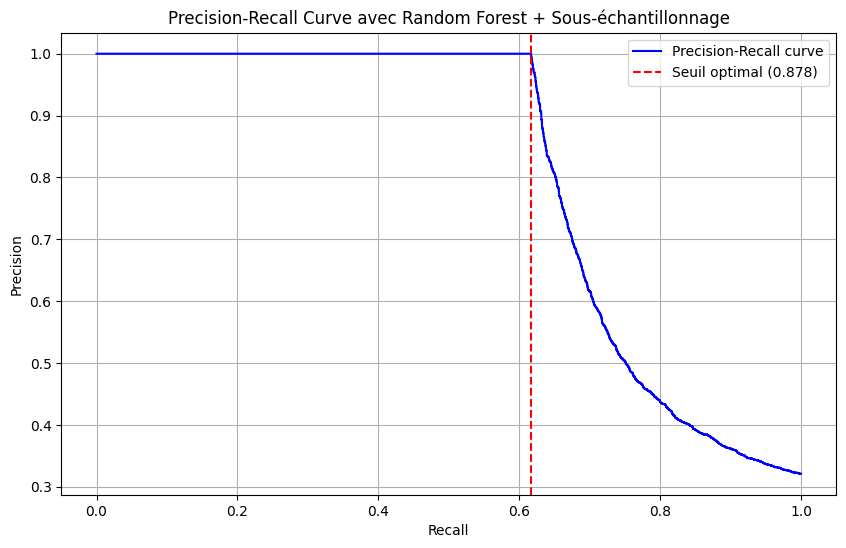

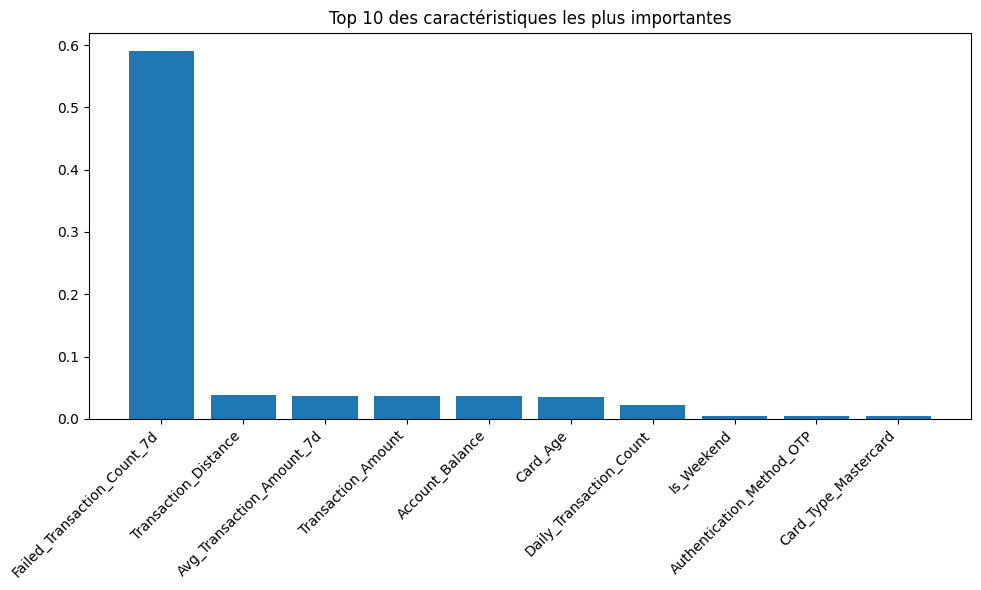

In [27]:
# 1. Appliquer le sous-échantillonnage pour équilibrer les classes
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, precision_recall_curve
import numpy as np

# Créer et appliquer le sous-échantillonneur
rus = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_final, y_train)

# Vérifier la distribution des classes après le sous-échantillonnage
print("Distribution des classes après sous-échantillonnage:")
print(np.bincount(y_train_balanced))

# 2. Créer et entraîner le modèle Random Forest
rf_balanced = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Entraîner le modèle sur les données équilibrées
rf_balanced.fit(X_train_balanced, y_train_balanced)

# 3. Évaluer le modèle
# Prédictions avec le seuil par défaut
y_pred_default = rf_balanced.predict(X_test_final)
print("\nRésultats avec le seuil par défaut (0.5):")
print(classification_report(y_test, y_pred_default))

# Optimiser le seuil de décision
probas = rf_balanced.predict_proba(X_test_final)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probas)

# Calculer le F1 score pour chaque seuil
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Appliquer le seuil optimal
y_pred_optimized = (probas >= optimal_threshold).astype(int)

print("\nRésultats avec le seuil optimal:")
print(classification_report(y_test, y_pred_optimized))
print(f"Seuil optimal: {optimal_threshold:.3f}")

# Visualiser la courbe precision-recall
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve avec Random Forest + Sous-échantillonnage')
plt.axvline(x=recalls[np.argmax(f1_scores)], color='r', linestyle='--', 
            label=f'Seuil optimal ({optimal_threshold:.3f})')
plt.legend()
plt.grid(True)
plt.show()

# Afficher l'importance des caractéristiques
feature_importance = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': rf_balanced.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(range(10), feature_importance['importance'][:10])
plt.xticks(range(10), feature_importance['feature'][:10], rotation=45, ha='right')
plt.title('Top 10 des caractéristiques les plus importantes')
plt.tight_layout()
plt.show()

Training class distribution after RUS: [12050 12050]

[Default Threshold 0.5] Performance:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500


Optimal threshold: 0.878
[Optimal Threshold] Performance:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500



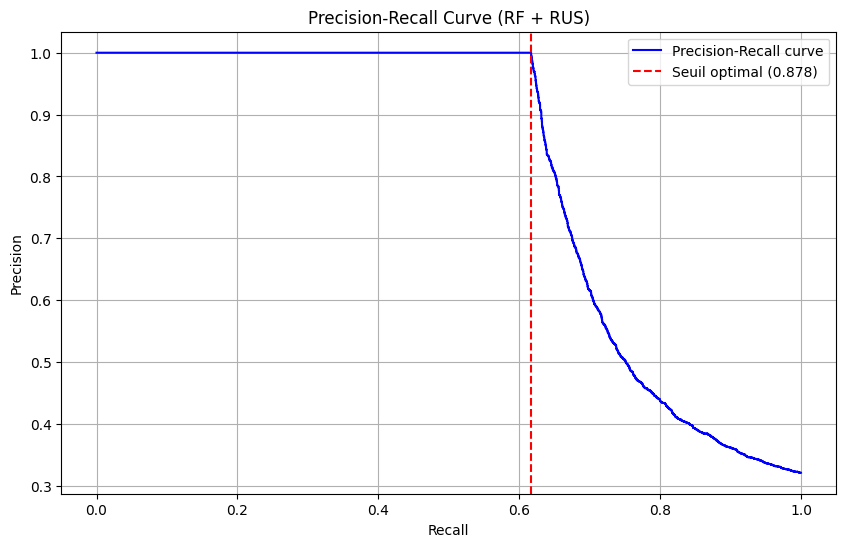

In [28]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# 1. Apply RandomUnderSampler ONLY to training set
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_final, y_train)

print("Training class distribution after RUS:", np.bincount(y_train_rus))

# 2. Train Random Forest WITHOUT class_weight (RUS already balanced the data)
rf_rus = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_rus.fit(X_train_rus, y_train_rus)

# 3. Evaluate with default threshold (0.5)
y_pred_default = rf_rus.predict(X_test_final)
print("\n[Default Threshold 0.5] Performance:")
print(classification_report(y_test, y_pred_default))

# 4. Find optimal threshold using Precision-Recall curve
probas = rf_rus.predict_proba(X_test_final)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probas)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
optimal_threshold = thresholds[np.argmax(f1_scores)]

# 5. Apply optimal threshold
y_pred_opt = (probas >= optimal_threshold).astype(int)
print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print("[Optimal Threshold] Performance:")
print(classification_report(y_test, y_pred_opt))

# 6. Visualize Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', label='Precision-Recall curve')
plt.axvline(x=recalls[np.argmax(f1_scores)], color='r', linestyle='--', 
            label=f'Seuil optimal ({optimal_threshold:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (RF + RUS)')
plt.legend()
plt.grid(True)
plt.show()


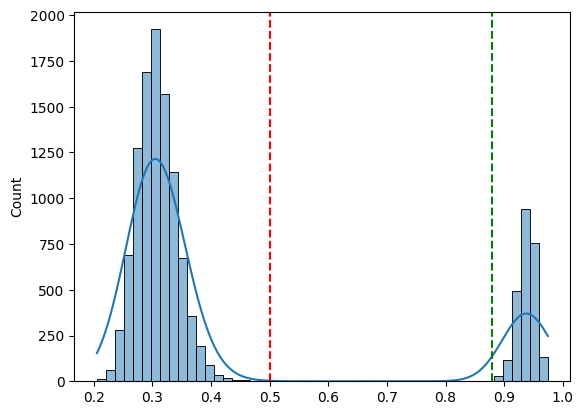

In [29]:
import seaborn as sns
sns.histplot(probas, bins=50, kde=True)
plt.axvline(0.5, color='r', linestyle='--')
plt.axvline(optimal_threshold, color='g', linestyle='--')
plt.show()


In [30]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # 70% ratio
X_rus, y_rus = rus.fit_resample(X_train, y_train)


In [31]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf_calibrated = CalibratedClassifierCV(rf, method='sigmoid', cv=3)
rf_calibrated.fit(X_rus, y_rus)


CalibratedClassifierCV(cv=3, estimator=RandomForestClassifier(random_state=42))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Meilleurs paramètres:
{'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

Résultats avec le modèle amélioré (seuil optimal):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500


Seuil optimal: 0.802

Résultats avec le seuil par défaut (0.5):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87    

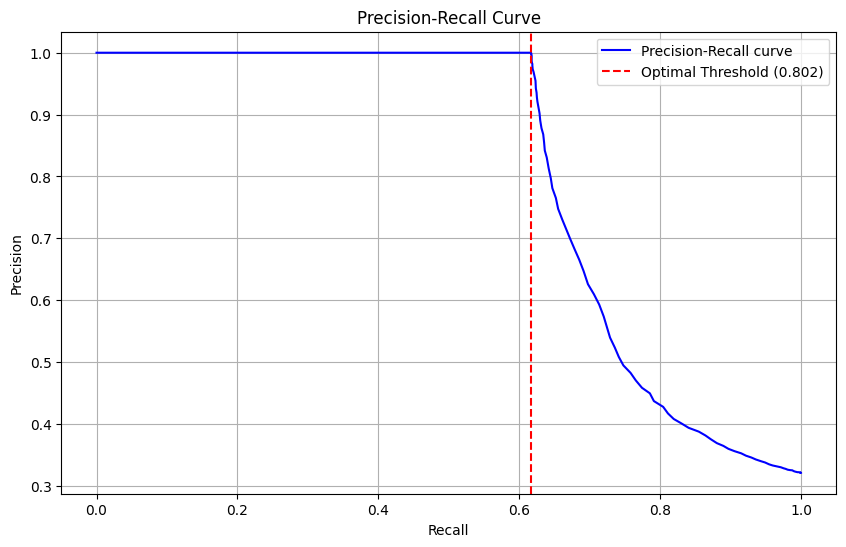

In [32]:
# 1. Appliquer SMOTE pour équilibrer les classes
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
import numpy as np

# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_final, y_train)

# 2. Créer une grille de paramètres plus détaillée
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample'],
}

# 3. GridSearchCV avec focus sur le recall
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='recall',  # Optimiser pour le recall
    n_jobs=-1,
    verbose=2
)

# Entraîner le modèle sur les données équilibrées
grid_search.fit(X_train_balanced, y_train_balanced)
best_rf_enhanced = grid_search.best_estimator_

print('\nMeilleurs paramètres:')
print(grid_search.best_params_)

# 4. Trouver le meilleur seuil de décision
probas = best_rf_enhanced.predict_proba(X_test_final)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probas)                    

# Calculer le F1 score pour chaque seuil
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Appliquer le seuil optimal
y_pred_optimized = (probas >= optimal_threshold).astype(int)

print("\nRésultats avec le modèle amélioré (seuil optimal):")
print(classification_report(y_test, y_pred_optimized))
print(f"\nSeuil optimal: {optimal_threshold:.3f}")

print("\nRésultats avec le seuil par défaut (0.5):")
print(classification_report(y_test, best_rf_enhanced.predict(X_test_final)))

# Visualiser la courbe precision-recall
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.axvline(x=recalls[np.argmax(f1_scores)], color='r', linestyle='--', 
            label=f'Optimal Threshold ({optimal_threshold:.3f})')
plt.legend()
plt.grid(True)
plt.show()

**Random Forest Feature Importance (Gini vs. Permutation)**

We analyze feature importance using two methods:

**Mean Decrease in Gini (Gini Importance)**: This is a standard metric that measures a feature's contribution to reducing impurity during the tree-building process.

**Permutation Importance**: This method measures the decrease in model performance when a single feature's values are randomly shuffled, providing a more direct link to predictive power.

Both methods confirm that Failed_Transaction_Count_7d is the most important feature.

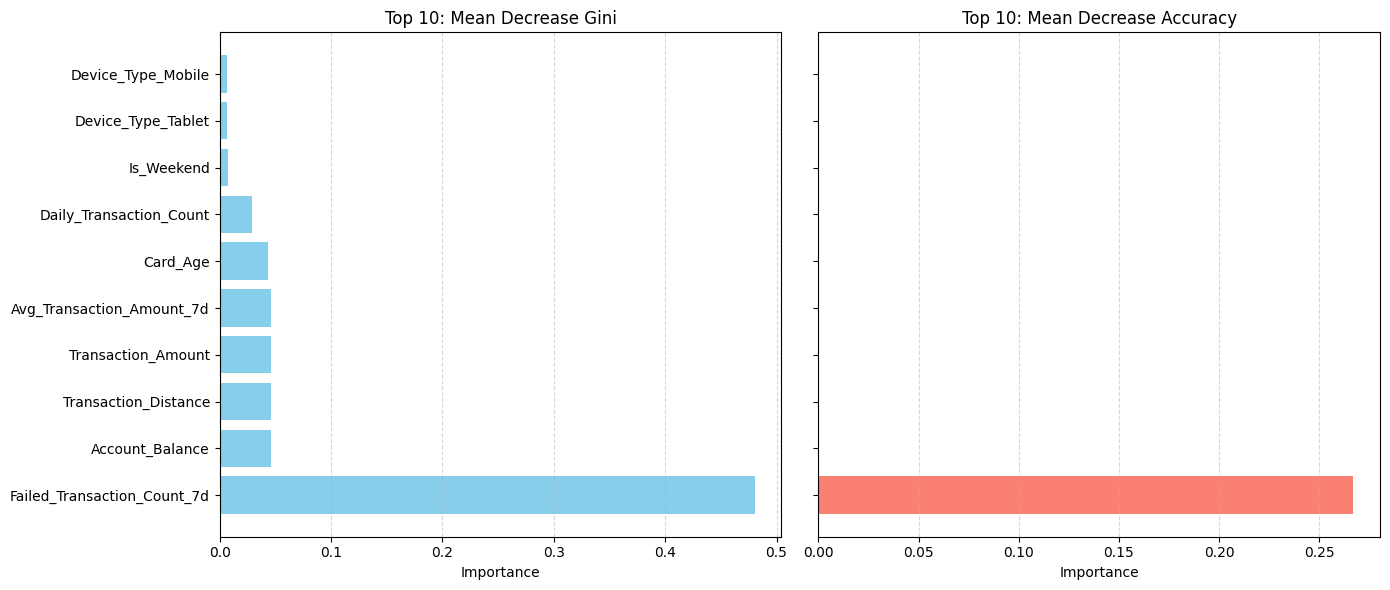

In [33]:
perm = permutation_importance(best_rf_model, X_test_final, y_test, n_repeats=5, random_state=42, n_jobs=-1)

# Combine importances
importance_df = pd.DataFrame({
    'Feature': X_test_final.columns,
    'MeanDecreaseGini': best_rf_model.feature_importances_,
    'MeanDecreaseAccuracy': perm.importances_mean
})

# Sort by Gini importance and get top 10
top_features = importance_df.sort_values(by='MeanDecreaseGini', ascending=False).head(10)

# Plot top 10 features
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].barh(top_features['Feature'], top_features['MeanDecreaseGini'], color='skyblue')
axes[0].set_title('Top 10: Mean Decrease Gini')
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis()
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

axes[1].barh(top_features['Feature'], top_features['MeanDecreaseAccuracy'], color='salmon')
axes[1].set_title('Top 10: Mean Decrease Accuracy')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

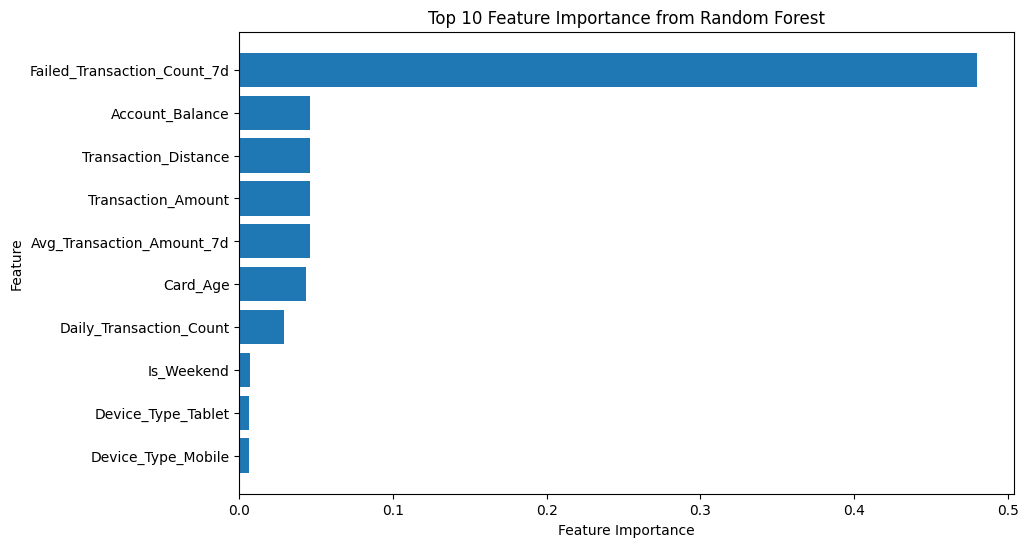

,Feature,Importance
6,Failed_Transaction_Count_7d,0.480352
1,Account_Balance,0.046171
8,Transaction_Distance,0.046008
0,Transaction_Amount,0.045792
5,Avg_Transaction_Amount_7d,0.045745
7,Card_Age,0.043331
4,Daily_Transaction_Count,0.028808
9,Is_Weekend,0.007177
16,Device_Type_Tablet,0.006149
15,Device_Type_Mobile,0.006107


In [34]:
# Get feature importances
importances = best_rf_model.feature_importances_
feature_names = X_train_final.columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot top N features (e.g., top 10)
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:top_n], feature_importance_df['Importance'][:top_n])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importance from Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Display the top N features in a table
feature_importance_df.head(top_n)

******************************

In [35]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Update your Random Forest with class weights
best_rf_model2 = RandomForestClassifier(
    random_state=42,
    class_weight=class_weights,
    n_estimators=100,  # From your grid search
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1
)
best_rf_model2.fit(X_train_final, y_train)

RandomForestClassifier(class_weight={np.int64(0): np.float64(0.7367387033398821),
                                     np.int64(1): np.float64(1.5560165975103735)},
                       n_jobs=-1, random_state=42)

In [36]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_probs = best_rf_model2.predict_proba(X_test_final)[:, 1]

# Find optimal threshold (you can adjust beta for recall/preference)
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Apply threshold
y_pred_optimized = (y_probs >= optimal_threshold).astype(int)

print("\nOptimized Threshold Classification Report:")
print(classification_report(y_test, y_pred_optimized))
print("Optimal Threshold:", optimal_threshold)


Optimized Threshold Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500

Optimal Threshold: 0.8


In [37]:
# Add interaction features for top important features using original X_train/X_test
X_train_final['FailedTx_AmountRatio'] = X_train['Failed_Transaction_Count_7d'] / (X_train['Avg_Transaction_Amount_7d'] + 1e-6)
X_test_final['FailedTx_AmountRatio'] = X_test['Failed_Transaction_Count_7d'] / (X_test['Avg_Transaction_Amount_7d'] + 1e-6)

# Add temporal features using original X_train/X_test
X_train_final['Hour_sin'] = np.sin(2 * np.pi * X_train['Hour'] / 24)
X_train_final['Hour_cos'] = np.cos(2 * np.pi * X_train['Hour'] / 24)
X_test_final['Hour_sin'] = np.sin(2 * np.pi * X_test['Hour'] / 24)
X_test_final['Hour_cos'] = np.cos(2 * np.pi * X_test['Hour'] / 24)

# Update feature list
numeric_features.extend(['FailedTx_AmountRatio', 'Hour_sin', 'Hour_cos'])

KeyError: 'Hour'

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# 1. Data Quality Check
print("Missing values in X_train_final:", X_train_final.isna().sum().sum())
print("Infinite values in X_train_final:", np.isinf(X_train_final.values).sum())

# 2. Handle any remaining issues
X_train_final = X_train_final.replace([np.inf, -np.inf], np.nan)
X_train_final = X_train_final.fillna(X_train_final.mean())

# 3. Enhanced Parameter Grid with safer ranges
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'class_weight': [None, 'balanced', {0:1, 1:2}],
    'max_samples': [0.7, 0.8, None]
}

# 4. Create more robust scoring
scorer = make_scorer(f1_score, average='binary', pos_label=1)

# 5. Configure RandomizedSearchCV with error handling
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring=scorer,
    random_state=42,
    n_jobs=-1,
    verbose=2,
    error_score='raise'  # Will show full error if any
)

# 6. Fit with clean data
try:
    rf_random.fit(X_train_final, y_train)
    best_rf = rf_random.best_estimator_
    print("\nBest Parameters:", rf_random.best_params_)
    
    # 7. Evaluate
    y_pred = best_rf.predict(X_test_final)
    print(classification_report(y_test, y_pred))
    
except Exception as e:
    print(f"Error during fitting: {str(e)}")
    print("Check your data for invalid values or extreme outliers")

Missing values in X_train_final: 0
Infinite values in X_train_final: 0
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\amine\Downloads\detection de fraud\.venv\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500



In [ ]:
# Define cost matrix (adjust based on your business needs)
# [TN, FP]
# [FN, TP]
cost_matrix = np.array([[0, 5],  # Cost of false positives (annoying customers)
                       [50, 0]]) # Cost of false negatives (fraud losses)

def business_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return np.sum(cm * cost_matrix)

# Evaluate
y_pred_default = best_rf.predict(X_test_final)
default_cost = business_cost(y_test, y_pred_default)

y_pred_optimized = (best_rf.predict_proba(X_test_final)[:, 1] >= optimal_threshold).astype(int)
optimized_cost = business_cost(y_test, y_pred_optimized)

print(f"Default Threshold Cost: ${default_cost:,}")
print(f"Optimized Threshold Cost: ${optimized_cost:,}")

Default Threshold Cost: $76,950
Optimized Threshold Cost: $76,950


In [ ]:
# 1. Use a smaller subset for development
sample_size = 10000  # Adjust based on your system
X_sample = X_train_final.sample(sample_size, random_state=42)
y_sample = y_train.loc[X_sample.index]

# 2. Replace SVC with faster alternative
from sklearn.linear_model import SGDClassifier

estimators_fast = [
    ('rf', best_rf_model2),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1)),
    ('sgd', SGDClassifier(loss='log_loss', random_state=42))
]

stacking_fast = StackingClassifier(
    estimators=estimators_fast,
    final_estimator=LogisticRegression(),
    cv=3,  # Reduced from 5
    n_jobs=-1
)

stacking_fast.fit(X_sample, y_sample)

StackingClassifier(cv=3,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight={np.int64(0): np.float64(0.7367387033398821),
                                                                     np.int64(1): np.float64(1.5560165975103735)},
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stoppi...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=-1,
                                              num_parallel_tree=None, ...)),
                               ('sgd',
                                SGDClassifier(loss='log_loss',
                                              random_state=42))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [ ]:
from scipy.stats import ks_2samp
# Track model drift over time
def monitor_drift(model, X_historical, X_current):
    # Compare feature distributions
    drift_scores = []
    for col in X_historical.columns:
        ks_stat, _ = ks_2samp(X_historical[col], X_current[col])
        drift_scores.append(ks_stat)
    
    return pd.Series(drift_scores, index=X_historical.columns).sort_values(ascending=False)

# Example usage
drift_results = monitor_drift(best_rf_model, X_train_final, X_test_final)
print("Top drifting features:")
print(drift_results.head(10))

Top drifting features:
Transaction_Amount             0.012293
Hour_sin                       0.010667
Failed_Transaction_Count_7d    0.010613
Location_New York              0.008613
FailedTx_AmountRatio           0.008427
Hour_cos                       0.007600
Device_Type_Mobile             0.007573
Avg_Transaction_Amount_7d      0.006800
Transaction_Type_Online        0.006347
Month_7                        0.006000
dtype: float64


2.4 Model 3: XGBoost Classifier

--- Étape 1: Entraînement du modèle XGBoost ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Meilleurs paramètres pour XGBoost :
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}

Performance de XGBoost avec seuil par défaut (0.5) :
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500


--- Étape 2: Recherche du seuil optimal pour XGBoost ---

Seuil optimal trouvé (pour Précision >= 0.82): 0.2076

--- Performance avec le nouveau seuil optimal (0.2076) ---
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      8483
           1       0.82      0.64      0.72      4017

    accuracy                           0.84     12500
   m

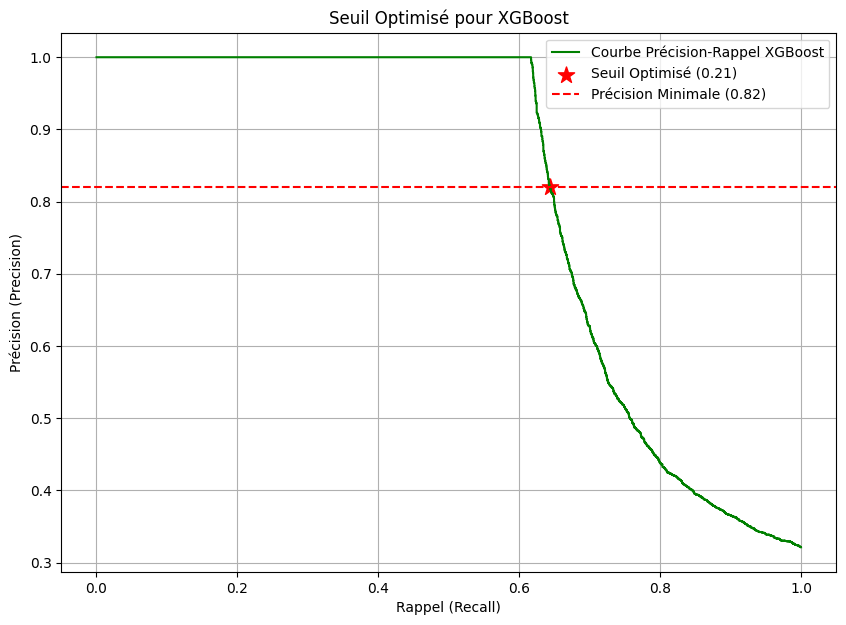

In [ ]:
# --- Entraînement et Optimisation Complète de XGBoost ---

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# --- Partie 1: Entraînement du modèle XGBoost ---

print("--- Étape 1: Entraînement du modèle XGBoost ---")
# Grille de paramètres pour la recherche
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10], # Profondeurs légèrement plus élevées peuvent être bénéfiques
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Recherche par grille avec validation croisée
grid_search_xgb = GridSearchCV(
    XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    param_grid_xgb,
    scoring='f1',
    cv=3,
    verbose=1, # Réduit à 1 pour moins de logs
    n_jobs=-1
)

# Entraînement et sélection du meilleur modèle
grid_search_xgb.fit(X_train_final, y_train)
best_xgb_model = grid_search_xgb.best_estimator_

print('\nMeilleurs paramètres pour XGBoost :')
print(grid_search_xgb.best_params_)
print("\nPerformance de XGBoost avec seuil par défaut (0.5) :")
print(classification_report(y_test, best_xgb_model.predict(X_test_final)))


# --- Partie 2: Recherche d'un Seuil Optimisé (Focus sur le Rappel) ---

print("\n--- Étape 2: Recherche du seuil optimal pour XGBoost ---")

# Prédire les probabilités sur l'ensemble de test
y_proba_xgb = best_xgb_model.predict_proba(X_test_final)[:, 1]

# Calculer la courbe Précision-Rappel
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_test, y_proba_xgb)

# Définir la contrainte de précision minimale
MIN_PRECISION_XGB = 0.82

# Trouver le meilleur seuil qui respecte la contrainte
valid_indices_xgb = np.where(precisions_xgb[:-1] >= MIN_PRECISION_XGB)[0]

if len(valid_indices_xgb) > 0:
    # Parmi les seuils valides, trouver celui qui maximise le rappel
    best_idx_xgb = valid_indices_xgb[np.argmax(recalls_xgb[valid_indices_xgb])]
    new_optimal_threshold_xgb = thresholds_xgb[best_idx_xgb]

    print(f"\nSeuil optimal trouvé (pour Précision >= {MIN_PRECISION_XGB}): {new_optimal_threshold_xgb:.4f}")

    # Appliquer le nouveau seuil
    y_pred_new_optimal_xgb = (y_proba_xgb >= new_optimal_threshold_xgb).astype(int)

    # Afficher le rapport de classification final
    print(f"\n--- Performance avec le nouveau seuil optimal ({new_optimal_threshold_xgb:.4f}) ---")
    print(classification_report(y_test, y_pred_new_optimal_xgb))
    
    # Visualisation
    plt.figure(figsize=(10, 7))
    plt.plot(recalls_xgb[:-1], precisions_xgb[:-1], 'g-', label='Courbe Précision-Rappel XGBoost')
    plt.xlabel('Rappel (Recall)')
    plt.ylabel('Précision (Precision)')
    plt.title('Seuil Optimisé pour XGBoost')
    plt.scatter(recalls_xgb[best_idx_xgb], precisions_xgb[best_idx_xgb], marker='*', color='red', s=150, label=f'Seuil Optimisé ({new_optimal_threshold_xgb:.2f})')
    plt.axhline(y=MIN_PRECISION_XGB, color='r', linestyle='--', label=f'Précision Minimale ({MIN_PRECISION_XGB})')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

else:
    print(f"\nAucun seuil n'a été trouvé qui satisfait une précision d'au moins {MIN_PRECISION_XGB}.")
    print("Essayez de réduire la valeur de MIN_PRECISION_XGB.")


In [ ]:
# --- Affichage Complet du Rapport de Classification ---

# On utilise les variables `y_test` et `y_pred_new_optimal_xgb` de la cellule précédente

print(f"--- Rapport de Classification Complet (Seuil = {new_optimal_threshold_xgb:.4f}) ---\n")

# 1. Générer le rapport sous forme de chaîne de caractères
full_report = classification_report(y_test, y_pred_new_optimal_xgb)

# 2. Imprimer le rapport complet
print(full_report)

# 3. Extraire et afficher les métriques pour la classe 1 (Fraude) de manière plus détaillée
report_dict = classification_report(y_test, y_pred_new_optimal_xgb, output_dict=True)
fraud_metrics = report_dict['1']

print("\n--- Focus sur la Classe 1 (Fraude) ---")
print(f"Précision : {fraud_metrics['precision']:.2f} (Le modèle est correct dans {fraud_metrics['precision']:.0%} des cas quand il prédit une fraude)")
print(f"Rappel (Recall) : {fraud_metrics['recall']:.2f} (Le modèle détecte {fraud_metrics['recall']:.0%} de toutes les fraudes réelles)")
print(f"F1-Score : {fraud_metrics['f1-score']:.2f} (Moyenne harmonique de la précision et du rappel)")

--- Rapport de Classification Complet (Seuil = 0.2076) ---

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      8483
           1       0.82      0.64      0.72      4017

    accuracy                           0.84     12500
   macro avg       0.83      0.79      0.80     12500
weighted avg       0.84      0.84      0.83     12500


--- Focus sur la Classe 1 (Fraude) ---
Précision : 0.82 (Le modèle est correct dans 82% des cas quand il prédit une fraude)
Rappel (Recall) : 0.64 (Le modèle détecte 64% de toutes les fraudes réelles)
F1-Score : 0.72 (Moyenne harmonique de la précision et du rappel)


XGBoost is a powerful gradient boosting algorithm. The baseline model achieves 87% accuracy and, like the Random Forest, has nearly perfect precision (0.98) for fraud detection but a moderate recall of 0.62.


After hyperparameter tuning, the performance remains very similar, confirming the strength of the baseline model.

In [ ]:
# Original model
xgb_model = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_model.fit(X_train_final, y_train)

print('\n[Original] XGBoost Classifier')
print(classification_report(y_test, xgb_model.predict(X_test_final)))

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8, 1.0]
}

# Grid search
grid_search = GridSearchCV(
    XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit and compare
grid_search.fit(X_train_final, y_train)
best_xgb_model = grid_search.best_estimator_

print('\n[Tuned] XGBoost Classifier (Best Params):')
print(grid_search.best_params_)
print(classification_report(y_test, best_xgb_model.predict(X_test_final)))


[Original] XGBoost Classifier
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      8483
           1       0.98      0.62      0.76      4017

    accuracy                           0.87     12500
   macro avg       0.91      0.81      0.84     12500
weighted avg       0.89      0.87      0.86     12500

Fitting 3 folds for each of 16 candidates, totalling 48 fits

[Tuned] XGBoost Classifier (Best Params):
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500



**XGBoost Feature Importance**

We visualize the feature importances from the tuned XGBoost model. This shows which features the boosting algorithm relied on most heavily to make its predictions.

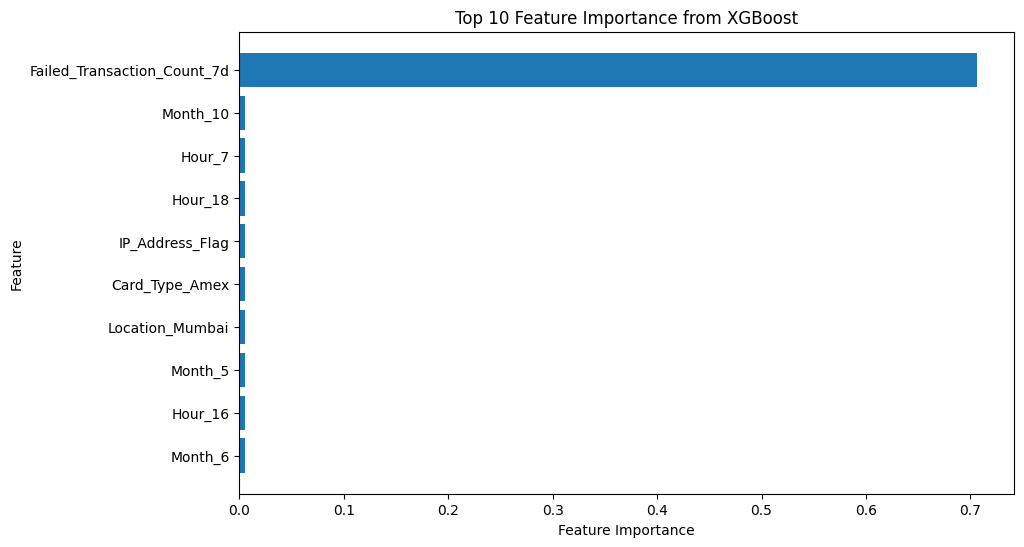

                        Feature  Importance
6   Failed_Transaction_Count_7d    0.706663
68                     Month_10    0.005895
42                       Hour_7    0.005548
53                      Hour_18    0.005398
2               IP_Address_Flag    0.005227
27               Card_Type_Amex    0.005183
18              Location_Mumbai    0.005157
63                      Month_5    0.005106
51                      Hour_16    0.005077
64                      Month_6    0.005004


In [ ]:
importances = best_xgb_model.feature_importances_
feature_names = X_train_final.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:top_n], feature_importance_df['Importance'][:top_n])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importance from XGBoost")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

print(feature_importance_df.head(10))

**3. Simplified Modeling: Numerical Features Only**

**3.1 Data Preparation**

We create a new DataFrame containing only the numerical features and the target variable. We then perform a standard train-test split and scale the features.

In [ ]:
df_num = df[numeric_features + [target]]
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    df_num.drop(columns=[target]),
    df_num[target],
    test_size=0.25,
    random_state=42,
    stratify=df_num[target]
)

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

**5.2 K-Nearest Neighbors (KNN)**

We first use GridSearchCV to find the optimal number of neighbors (k) for the KNN model.

In [ ]:
param_grid = {'n_neighbors': np.arange(2,18,1)}
knn_cv = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
knn_cv.fit(X_train_num_scaled, y_train_num)
print(f"Best n_neighbors: {knn_cv.best_params_['n_neighbors']}")
best_knn = knn_cv.best_estimator_

Best n_neighbors: 14


Now, we train the final KNN model using the best n_neighbors value and evaluate its performance.

In [ ]:
# Create and train KNN model
knn_model = KNeighborsClassifier(n_neighbors=14)

# Use scaled features for KNN
knn_model.fit(X_train_num_scaled, y_train_num)
predictions = knn_model.predict(X_test_num_scaled)

# Evaluate on test set
print('\nKNN Classifier')
print(classification_report(y_test_num, knn_model.predict(X_test_num_scaled)))


KNN Classifier
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       0.99      0.61      0.76      4017

    accuracy                           0.87     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.89      0.87      0.87     12500



6. **Export the model**

In [ ]:
import joblib
joblib.dump(best_rf_model, 'fraud_rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(one_hot_encoder, 'encoder.pkl')


['encoder.pkl']

In [ ]:
# After model training
joblib.dump(X_train_final.columns.tolist(), 'feature_order.pkl')


['feature_order.pkl']

**Test**

In [ ]:
import pandas as pd

# Fraud transaction example

# new_transaction = pd.DataFrame([{
#     'Transaction_Amount': 5000.00,                  # Unusually high for the account
#     'Transaction_Type': 'Debit',                    # Money going out
#     'Account_Balance': 5200.00,                      # Nearly full balance being drained
#     'Device_Type': 'Web',                            # Not the usual device
#     'Location': 'Nigeria',                           # Different country than normal
#     'Merchant_Category': 'Electronics',              # High resale value items
#     'IP_Address_Flag': 1,                            # IP flagged as suspicious
#     'Previous_Fraudulent_Activity': 1,               # Has previous fraud history
#     'Daily_Transaction_Count': 7,                    # Many transactions in one day
#     'Avg_Transaction_Amount_7d': 150.00,              # Normally small transactions
#     'Failed_Transaction_Count_7d': 4,                # Multiple recent failed attempts
#     'Card_Type': 'Visa',                              # Commonly targeted
#     'Card_Age': 0.5,                                  # New card (half a month)
#     'Transaction_Distance': 5000,                     # Very far from normal location
#     'Authentication_Method': 'None',                  # No 2FA or PIN used
#     'Is_Weekend': 1,                                  # Weekend transaction
#     'Hour': 3,                                        # Middle of the night
#     'Month': 8,
#     'Year': 2025
# }])


# Legit transaction example

# new_transaction = pd.DataFrame([{
#     'Transaction_Amount': 45.00,                     # Small, normal purchase
#     'Transaction_Type': 'Credit',                    # Money coming into the account
#     'Account_Balance': 1200.00,                       # Normal balance
#     'Device_Type': 'Mobile',                          # Usual device for the user
#     'Location': 'Paris',                              # Usual location
#     'Merchant_Category': 'Groceries',                 # Common spending category
#     'IP_Address_Flag': 0,                             # Clean IP
#     'Previous_Fraudulent_Activity': 0,                # No history of fraud
#     'Daily_Transaction_Count': 2,                     # Normal daily activity
#     'Avg_Transaction_Amount_7d': 40.00,               # Similar to usual amounts
#     'Failed_Transaction_Count_7d': 0,                 # No failed transactions
#     'Card_Type': 'MasterCard',                        # Usual card
#     'Card_Age': 24,                                   # Card held for 2 years
#     'Transaction_Distance': 2,                        # Local transaction
#     'Authentication_Method': 'PIN',                   # Secure authentication
#     'Is_Weekend': 0,                                  # Weekday
#     'Hour': 17,                                       # Afternoon shopping
#     'Month': 8,
#     'Year': 2025
# }])


# Hard Fraud Transaction Example

# new_transaction = pd.DataFrame([{
    # 'Transaction_Amount': 320.00,                    # Medium amount (not huge, not tiny)
    # 'Transaction_Type': 'Debit',                     # Money going out
    # 'Account_Balance': 1500.00,                       # Normal balance
    # 'Device_Type': 'Mobile',                          # Usual device type
    # 'Location': 'London',                             # Slightly unusual (normally Paris)
    # 'Merchant_Category': 'Luxury Apparel',            # High resale value goods
    # 'IP_Address_Flag': 0,                             # Clean IP (no flag)
    # 'Previous_Fraudulent_Activity': 0,                # No known past fraud
    # 'Daily_Transaction_Count': 1,                     # Only one today
    # 'Avg_Transaction_Amount_7d': 60.00,               # Much smaller than today’s amount
    # 'Failed_Transaction_Count_7d': 1,                 # A small failed attempt earlier
    # 'Card_Type': 'Visa',                              # Common card type
    # 'Card_Age': 4,                                    # Card active for 4 months
    # 'Transaction_Distance': 450,                      # Farther than usual but not extreme
    # 'Authentication_Method': 'PIN',                   # Secure method (makes it harder)
    # 'Is_Weekend': 0,                                  # Weekday
    # 'Hour': 19,                                       # Evening shopping time
    # 'Month': 8,
    # 'Year': 2025
# }])

# Hard Non-Fraud Transaction Example


new_transaction = pd.DataFrame([{
    'Transaction_Amount': 2100.00,                   # High amount (could look suspicious)
    'Transaction_Type': 'Debit',                     # Money going out
    'Account_Balance': 9000.00,                       # Plenty of funds available
    'Device_Type': 'Web',                             # User’s usual purchase method for big items
    'Location': 'Tokyo',                              # Different country — user is on vacation
    'Merchant_Category': 'Electronics',               # High value, but purchased often when abroad
    'IP_Address_Flag': 0,                             # Clean IP
    'Previous_Fraudulent_Activity': 0,                # No fraud history
    'Daily_Transaction_Count': 1,                     # Only one transaction that day
    'Avg_Transaction_Amount_7d': 1800.00,              # Similar to today’s amount (habit for trips)
    'Failed_Transaction_Count_7d': 0,                 # No failed attempts
    'Card_Type': 'MasterCard',                        # Usual card
    'Card_Age': 60,                                   # Long-term card ownership (5 years)
    'Transaction_Distance': 9800,                     # Huge distance, but user has history of travel
    'Authentication_Method': 'OTP',                   # Strong authentication
    'Is_Weekend': 1,                                  # Weekend shopping abroad
    'Hour': 11,                                       # Normal daytime transaction
    'Month': 8,
    'Year': 2025
}])



In [ ]:
# Load saved objects
import joblib

model = joblib.load('fraud_rf_model.pkl')
encoder = joblib.load('encoder.pkl')
scaler = joblib.load('scaler.pkl')
feature_order = joblib.load('feature_order.pkl')
# List of features
categorical_features = ['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category',
                        'Card_Type', 'Authentication_Method', 'Hour', 'Month', 'Year']

numeric_features = ['Transaction_Amount', 'Account_Balance', 'Daily_Transaction_Count',
                    'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age',
                    'Transaction_Distance']

# Encode categorical
encoded = encoder.transform(new_transaction[categorical_features])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))

# Scale numerical
scaled = scaler.transform(new_transaction[numeric_features])
scaled_df = pd.DataFrame(scaled, columns=numeric_features)

# Boolean + combine all
boolean_features = ['IP_Address_Flag', 'Is_Weekend', 'Previous_Fraudulent_Activity']
booleans_df = new_transaction[boolean_features].reset_index(drop=True)

# Final test sample
X_new = pd.concat([scaled_df.reset_index(drop=True),
                   booleans_df,
                   encoded_df.reset_index(drop=True)], axis=1)
X_new = X_new.reindex(columns=feature_order, fill_value=0)


In [ ]:
prediction = model.predict(X_new)
probability = model.predict_proba(X_new)

print("Prediction (0=Not Fraud, 1=Fraud):", prediction[0])
print("Probability [Not Fraud, Fraud]:", probability[0])


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- FailedTx_AmountRatio
- Hour_cos
- Hour_sin


In [ ]:
%pip install shap

import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)  # assuming model is a trained RandomForest

# Get SHAP values
shap_values = explainer.shap_values(X_new)

# Check if shap_values is a list (multi-class) or array (binary or regression)
if isinstance(shap_values, list):
    # Binary classification (list with 2 elements)
    shap_vals = shap_values[1]  # for class "1" (fraud)
else:
    # Binary classification (single array)
    shap_vals = shap_values

# Force plot for first instance
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_vals[0], X_new.iloc[0], matplotlib=True)


  You can safely remove it manually.
  You can safely remove it manually.


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 904.8 kB/s  0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 1.5 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.8 MB 1.2 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.8 MB 1.2 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.8 MB 1.2 MB/s eta 0:00:02
   -------------- ------------------------- 1.0/2.8 MB 853.0 kB/s eta 0:00:03
   ------------------ --------------------- 1.3/2.8 

ImportError: Numba needs NumPy 2.2 or less. Got NumPy 2.3.

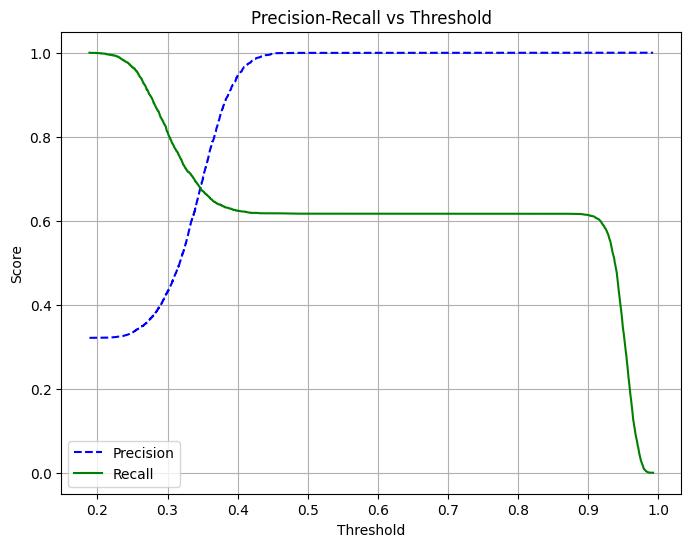

Classification Report with threshold = 0.39
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      8483
           1       0.91      0.63      0.74      4017

    accuracy                           0.86     12500
   macro avg       0.88      0.80      0.82     12500
weighted avg       0.87      0.86      0.85     12500

Confusion Matrix:
[[8238  245]
 [1491 2526]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Predict probabilities for fraud (class 1)
y_scores = rf_model.predict_proba(X_test_final)[:, 1]  # Use preprocessed test data

# Get precision-recall pairs for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Plot Precision vs Recall
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.title("Precision-Recall vs Threshold")
plt.show()

# ---------------------------
# Pick a custom threshold
# ---------------------------
custom_threshold = 0.39  # lower than 0.5 to catch more frauds

# Apply threshold
y_pred_custom = (y_scores >= custom_threshold).astype(int)

# See new performance
print("Classification Report with threshold =", custom_threshold)
print(classification_report(y_test, y_pred_custom))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))


In [ ]:
import numpy as np

# Show summary of fraud probabilities
print("Min:", np.min(y_scores))
print("Max:", np.max(y_scores))
print("Unique probability values:", np.unique(y_scores)[:20], "...")

# Check how many fall in the 0.3 - 0.5 range
mask_mid = (y_scores >= 0.3) & (y_scores < 0.5)
print("Transactions in [0.3, 0.5):", np.sum(mask_mid))


Min: 0.18867821248633831
Max: 0.9926282272431136
Unique probability values: [0.18867821 0.18937899 0.19067581 0.19470609 0.19603074 0.19723293
 0.19729699 0.19730153 0.19749228 0.19851548 0.19861808 0.19912988
 0.1995631  0.20094212 0.20100284 0.20112977 0.20154433 0.20290578
 0.20301556 0.20326983] ...
Transactions in [0.3, 0.5): 5087


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report

# --- You have already done this part ---
# y_probs = best_rf_model.predict_proba(X_test_final)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# -----------------------------------------

# Calculate the F1-score for each threshold
# Note: We need to handle the length mismatch between thresholds and precision/recall
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Find the threshold that gives the best F1 score
optimal_idx = np.argmax(f1_scores[:-1])  # thresholds is len-1 of precisions/recalls
optimal_threshold = thresholds[optimal_idx]

print(f"The optimal threshold that maximizes F1-score is: {optimal_threshold:.4f}")
print(f"At this threshold, F1-Score = {f1_scores[optimal_idx]:.4f}")

# Apply this optimal threshold to get new predictions
optimal_predictions = (y_scores >= optimal_threshold).astype(int)

# Evaluate the model with the optimal threshold
print("\n--- Classification Report with Optimal Threshold ---")
print(classification_report(y_test, optimal_predictions))

The optimal threshold that maximizes F1-score is: 0.4626
At this threshold, F1-Score = 0.7634

--- Classification Report with Optimal Threshold ---
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500



In [ ]:
# --- 5. Modèle 1 : Random Forest Optimisé (avec Analyse de Surapprentissage) ---

# Appliquer le sous-échantillonnage pour équilibrer les classes
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_final, y_train)

# Entraînement du modèle sur les données équilibrées
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=15,
    max_features="sqrt",
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)


rf_model.fit(X_train_balanced, y_train_balanced)

# --- Évaluation sur l'ensemble de Test ---
# Prédiction des probabilités
y_proba_rf = rf_model.predict_proba(X_test_final)[:, 1]

# Recherche du seuil optimal
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_test, y_proba_rf)
MIN_PRECISION_RF = 0.80
valid_indices_rf = np.where(precisions_rf[:-1] >= MIN_PRECISION_RF)[0]
best_idx_rf = valid_indices_rf[np.argmax(recalls_rf[valid_indices_rf])]
optimal_threshold_rf = thresholds_rf[best_idx_rf]

# Prédictions avec le seuil optimal
y_pred_rf_optimal = (y_proba_rf >= optimal_threshold_rf).astype(int)

print(f"\n--- Performance du Random Forest sur l'ensemble de TEST (Seuil = {optimal_threshold_rf:.3f}) ---")
print(classification_report(y_test, y_pred_rf_optimal))


# --- Analyse Overfitting / Underfitting ---
print("\n--- Analyse de la Généralisation du Modèle ---")

# Performance sur l'ensemble d'entraînement
y_pred_train_rf = (rf_model.predict_proba(X_train_balanced)[:, 1] >= optimal_threshold_rf).astype(int)
f1_train = f1_score(y_train_balanced, y_pred_train_rf)

# Performance sur l'ensemble de test
f1_test = f1_score(y_test, y_pred_rf_optimal)

# Comparaison et diagnostic
print(f"F1-Score sur l'ensemble d'entraînement : {f1_train:.4f}")
print(f"F1-Score sur l'ensemble de test : {f1_test:.4f}")
difference = f1_train - f1_test
print(f"Différence (Entraînement - Test) : {difference:.4f}")

if difference > 0.15:
    print("\n>> Diagnostic : Risque de SURAPPRENTISSAGE (Overfitting).")
elif f1_train < 0.8:
    print("\n>> Diagnostic : Risque de SOUS-APPRENTISSAGE (Underfitting).")
else:
    print("\n>> Diagnostic : Modèle SAIN et BIEN AJUSTÉ.")



--- Performance du Random Forest sur l'ensemble de TEST (Seuil = 0.366) ---
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      8483
           1       0.80      0.65      0.71      4017

    accuracy                           0.83     12500
   macro avg       0.82      0.78      0.80     12500
weighted avg       0.83      0.83      0.83     12500


--- Analyse de la Généralisation du Modèle ---
F1-Score sur l'ensemble d'entraînement : 0.8317
F1-Score sur l'ensemble de test : 0.7150
Différence (Entraînement - Test) : 0.1167

>> Diagnostic : Modèle SAIN et BIEN AJUSTÉ.


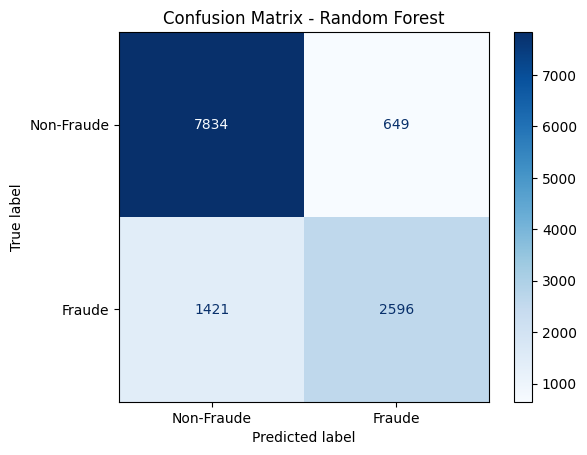

[[7834  649]
 [1421 2596]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcul de la confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_optimal)

# Affichage avec labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraude', 'Fraude'])
disp.plot(cmap=plt.cm.Blues)  # Couleur bleue
plt.title("Confusion Matrix - Random Forest")
plt.show()
cm = confusion_matrix(y_test, y_pred_rf_optimal)
print(cm)